In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series, column_name):
    print(f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value', 'No Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [183]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [2]:
data = pd.read_csv('hotel_bookings.csv')

In [16]:
# create a list of date columns for date related work
date_list = [col_name for i, col_name in enumerate(data.columns) if col_name.__contains__('date')]
date_list
time_data = pd.DataFrame(data[date_list])

In [17]:
from datetime import datetime
month_num = lambda x: datetime.strptime(x, '%B').month
time_data['arrival_date_month'] = time_data['arrival_date_month'].map(month_num)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date
0,2015,7,27,1,1/7/2015
1,2015,7,27,1,1/7/2015
2,2015,7,27,1,2/7/2015
3,2015,7,27,1,2/7/2015
4,2015,7,27,1,3/7/2015


In [18]:
# add in column arrival day for continuous time series by day of year
day_of_year = lambda year, month, day: datetime.strptime(f"{int(year)}-{int(month)}-{int(day)}", "%Y-%m-%d").timetuple().tm_yday
day_list = []
for i in range(len(time_data)):
    yr = time_data.arrival_date_year[i]
    mth = time_data.arrival_date_month[i]
    dy = time_data.arrival_date_day_of_month[i]
    x = day_of_year(yr, mth, dy)
    day_list.append(x)

time_data['year_day'] = pd.DataFrame(day_list, columns=['year_day'])
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day
0,2015,7,27,1,1/7/2015,182
1,2015,7,27,1,1/7/2015,182
2,2015,7,27,1,2/7/2015,182
3,2015,7,27,1,2/7/2015,182
4,2015,7,27,1,3/7/2015,182


In [19]:
year_format = lambda year, month, day: str(f'{day}/{month}/{year}')
time_data.loc[:,'arrival_date'] = time_data.apply(lambda x: year_format(x['arrival_date_year'], x['arrival_date_month'],
                                                                        x['arrival_date_day_of_month']), axis=1)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,arrival_date
0,2015,7,27,1,1/7/2015,182,1/7/2015
1,2015,7,27,1,1/7/2015,182,1/7/2015
2,2015,7,27,1,2/7/2015,182,1/7/2015
3,2015,7,27,1,2/7/2015,182,1/7/2015
4,2015,7,27,1,3/7/2015,182,1/7/2015


In [20]:
# count number of bookings per day and number of cancellations
time_data['arrival_date'] = pd.to_datetime(time_data['arrival_date'], format='%d/%m/%Y')

In [21]:
time_data = pd.concat([time_data, data['is_canceled']], axis = 1)

In [22]:
time_data_by_day = pd.DataFrame(time_data.groupby('arrival_date')['is_canceled'].sum())
time_data_by_day['total_bookings'] = pd.DataFrame(time_data['arrival_date'].value_counts())
time_data_by_day.head()

,is_canceled,total_bookings
arrival_date,,
2015-07-01,19,122
2015-07-02,57,93
2015-07-03,19,56
2015-07-04,43,88
2015-07-05,16,53


In [233]:
time_data_by_day[['is_canceled', 'total_bookings']].iloc[-30:].head(10)

,is_canceled,total_bookings
arrival_date,,
2017-08-02,48,150
2017-08-03,69,176
2017-08-04,57,163
2017-08-05,60,149
2017-08-06,57,148
2017-08-07,73,202
2017-08-08,54,139
2017-08-09,49,144
2017-08-10,58,147


In [213]:
time_data_by_day.is_canceled.iloc[-30:]

arrival_date
2017-08-02    48
2017-08-03    69
2017-08-04    57
2017-08-05    60
2017-08-06    57
2017-08-07    73
2017-08-08    54
2017-08-09    49
2017-08-10    58
2017-08-11    54
2017-08-12    64
2017-08-13    53
2017-08-14    64
2017-08-15    62
2017-08-16    91
2017-08-17    89
2017-08-18    81
2017-08-19    83
2017-08-20    45
2017-08-21    57
2017-08-22    26
2017-08-23    38
2017-08-24    58
2017-08-25    51
2017-08-26    69
2017-08-27    49
2017-08-28    64
2017-08-29    44
2017-08-30    27
2017-08-31    45
Name: is_canceled, dtype: int64

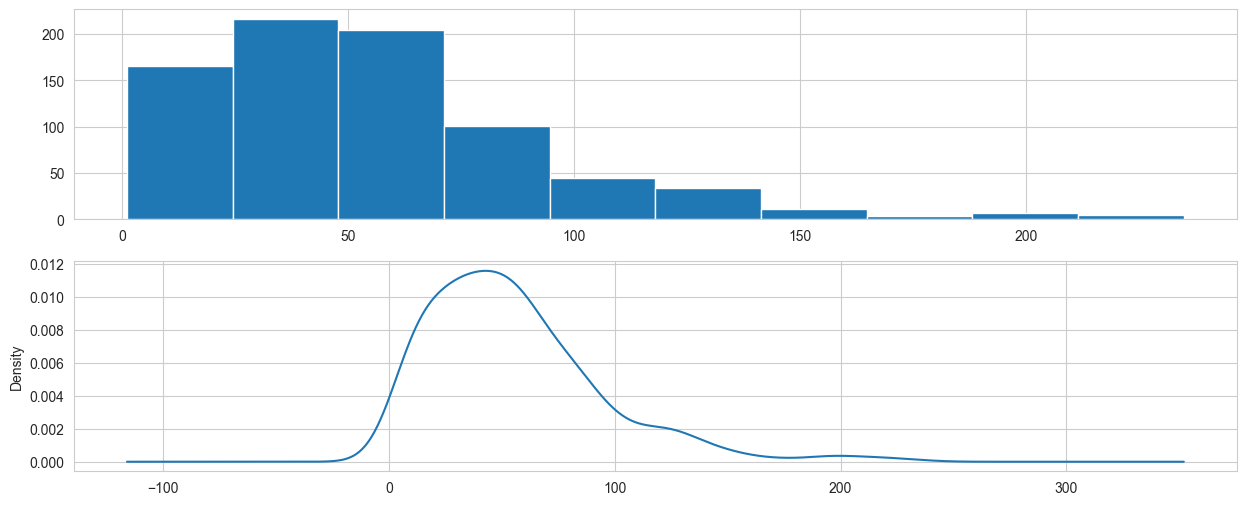

In [83]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
time_data_by_day["is_canceled"].hist()
plt.subplot(212)
time_data_by_day["is_canceled"].plot(kind='kde')
plt.show()

In [23]:
def create_lag(df: pd.DataFrame, colx:str = 'is_canceled', n_days:int = 14):
    df['lag1'] = df[f'{colx}'].shift(n_days)
    df['lag2'] = df[f'{colx}'].shift(2*n_days)
    df['lag3'] = df[f'{colx}'].shift(3*n_days)
    df = df.fillna(0)
    return df

In [24]:
time_train = pd.DataFrame(time_data_by_day.loc[time_data_by_day.index < '01-01-2017']).drop(index='2015-12-05')
time_test = pd.DataFrame(time_data_by_day.loc[time_data_by_day.index >= '01-01-2017'])

In [25]:
def create_feature(df):
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    return df

In [26]:
time_train = create_feature(time_train)
time_test = create_feature(time_test)

In [43]:
features = ['total_bookings', 'day_of_month', 'month', 'year',
            'day_of_year']
target = ['is_canceled']

In [44]:
X_train = time_train[features]
y_train = time_train[target]
X_test = time_test[features]
y_test = time_test[target]

In [45]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = True)

[0]	validation_0-rmse:63.86621	validation_1-rmse:72.93114
[1]	validation_0-rmse:63.29563	validation_1-rmse:72.30348
[2]	validation_0-rmse:62.73106	validation_1-rmse:71.68239
[3]	validation_0-rmse:62.17249	validation_1-rmse:71.06765
[4]	validation_0-rmse:61.61994	validation_1-rmse:70.45002
[5]	validation_0-rmse:61.07308	validation_1-rmse:69.84809
[6]	validation_0-rmse:60.53215	validation_1-rmse:69.24328
[7]	validation_0-rmse:59.99707	validation_1-rmse:68.65722
[8]	validation_0-rmse:59.46763	validation_1-rmse:68.06537
[9]	validation_0-rmse:58.94370	validation_1-rmse:67.48924
[10]	validation_0-rmse:58.42519	validation_1-rmse:66.92859
[11]	validation_0-rmse:57.91237	validation_1-rmse:66.36772
[12]	validation_0-rmse:57.40477	validation_1-rmse:65.81887
[13]	validation_0-rmse:56.90275	validation_1-rmse:65.26285
[14]	validation_0-rmse:56.40618	validation_1-rmse:64.70511
[15]	validation_0-rmse:55.91453	validation_1-rmse:64.17361
[16]	validation_0-rmse:55.42849	validation_1-rmse:63.64348
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [46]:
fi = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.head()

,importance
total_bookings,0.770025
day_of_month,0.057133
month,0.042136
year,0.068926
day_of_year,0.061780


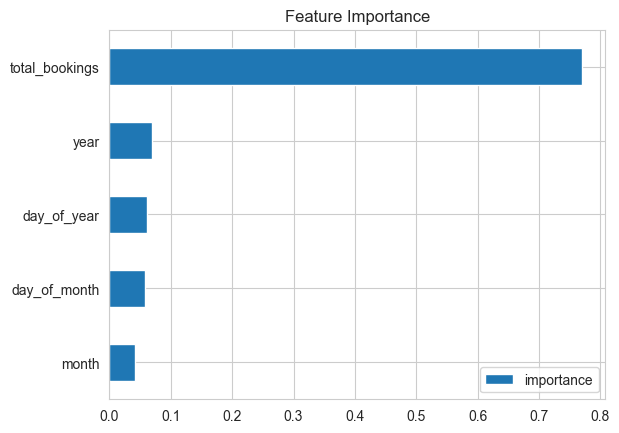

In [47]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [50]:
time_test['prediction'] = reg.predict(X_test)

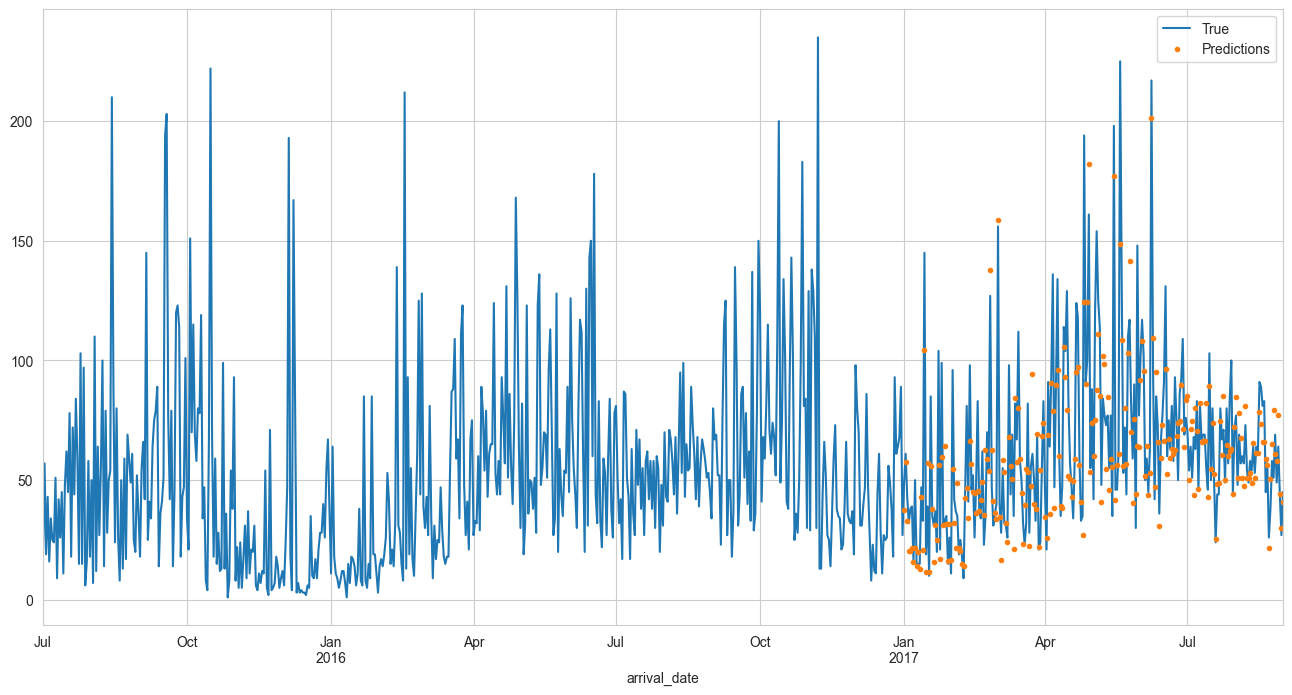

In [51]:
time_data_by_day = time_data_by_day.merge(time_test[['prediction']], how = 'left', left_index=True, right_index=True)
ax = time_data_by_day[['is_canceled']].plot(figsize=(16,8))
time_data_by_day['prediction'].plot(ax = ax, style = '.')
plt.legend(['True', 'Predictions'])
plt.show()

# Let's take a closer look at the predictions over the true values

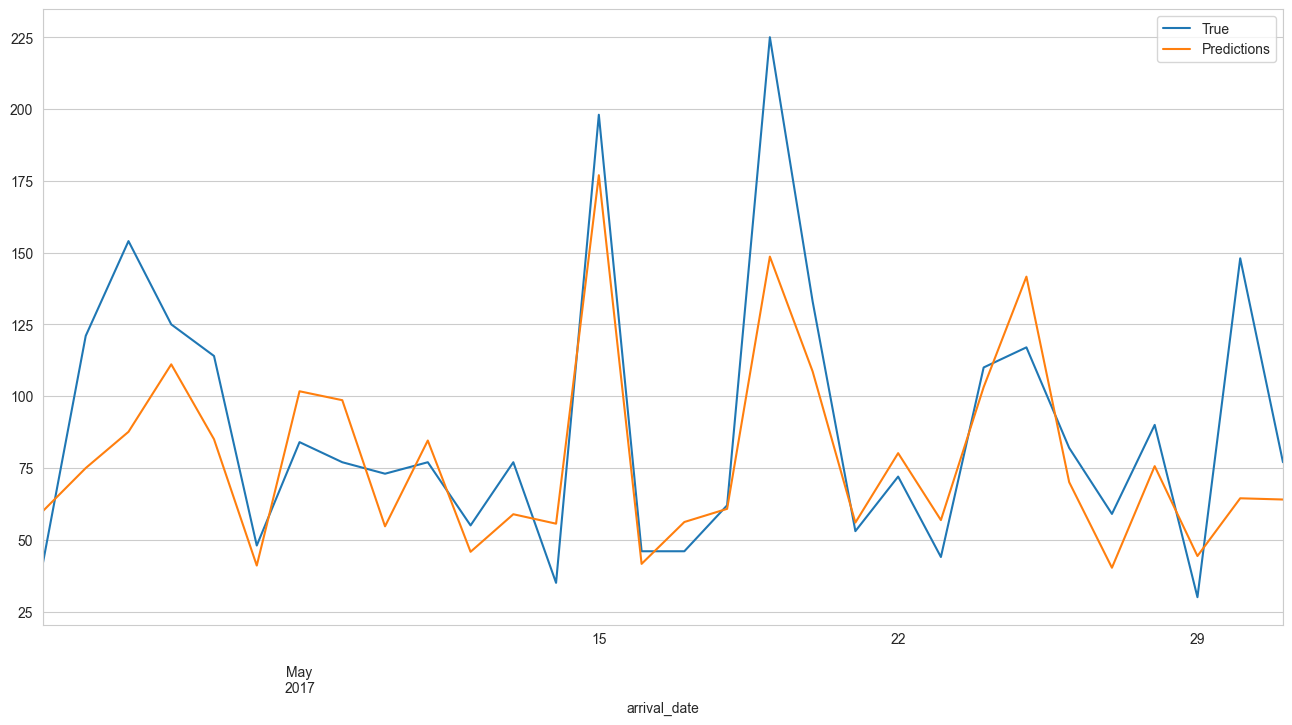

In [52]:
ax = time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['is_canceled'] \
    .plot(figsize=(16,8))
time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['prediction'] \
    .plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [104]:
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, f1_score, fbeta_score, mean_squared_error, classification_report

from sklearn.metrics._regression import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error, r2_score

def regression_report(y_true, y_pred):
    y_true, y_pred = np.ravel(y_true), np.ravel(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Append additional metrics to classification report
    reg_report = f"MSE: {mse}"\
                 f"\nMAE: {mae}"\
                 f"\nRMSE: {rmse}"\
                 f"\nMAPE: {mape}" \
                 f"\nR2 Score: {r2}"

    return reg_report

In [105]:
print(regression_report(y_true=time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['is_canceled'], y_pred=time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['prediction']))

MSE: 863.1319097175176
MAE: 21.414779408772787
RMSE: 29.379106686853458
MAPE: 0.23723599621024358
R2 Score: 0.6045242804705651


#### These results do have a higher error rate but maybe it might be because they are not using time lags, and they have a higher forecast window across the start of the year

In [107]:
time_data_by_day2 = pd.DataFrame(time_data.groupby('arrival_date')['is_canceled'].sum())
time_data_by_day_2 = create_lag(time_data_by_day2, n_days=30)
time_data_by_day_2.head()

,is_canceled,lag1,lag2,lag3
arrival_date,,,,
2015-07-01,19,0.0,0.0,0.0
2015-07-02,57,0.0,0.0,0.0
2015-07-03,19,0.0,0.0,0.0
2015-07-04,43,0.0,0.0,0.0
2015-07-05,16,0.0,0.0,0.0


In [108]:
time_data_by_day_2 = pd.concat([time_data_by_day.total_bookings, time_data_by_day_2], axis=1)

In [109]:
target_col = time_data_by_day_2[['is_canceled' ]].copy()
target_train, target_test = target_col[0:-30], target_col[-30:]
X_data = time_data_by_day_2.drop('is_canceled', axis=1)
X_data_train, X_data_test = X_data[0:-30], X_data[-30:]

In [111]:
# hyperopt imports to optimize the model simultaneously
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

In [118]:
def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(**space)

    #Define evaluation datasets.
    evaluation = [(X_data_train, target_train), (X_data_test, target_test)]
    evaluation_dart = [(X_data_test, target_test)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_data_train, target_train, eval_set = evaluation, verbose = False)
    #Obtain prediction and log_loss score.
    pred = model.predict(X_data_test)
    loss = mean_squared_error(target_test, pred,squared=False)
    print ("SCORE:", loss)

    #Specify what the loss is for each model.
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 15, 1)),
         'max_leaves': scope.int(hp.quniform("max_leaves", 1, 50, 1)),
         'gamma': hp.uniform ('gamma', 0,1),
         'reg_alpha' : hp.uniform('reg_alpha', 0,50),
         'reg_lambda' : hp.uniform('reg_lambda', 10,200),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
         'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
         'n_estimators': 10000,
         'learning_rate': hp.uniform('learning_rate', 0, .1),
         'tree_method':'gpu_hist',
         'gpu_id': 0,
         'random_state': 7,
         'max_bin' : scope.int(hp.quniform('max_bin', 200, 650, 1)),
         'eval_metric': 'rmse',
         'early_stopping_rounds': 100
         }

In [119]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:                                                
11.79168125236227                                     
SCORE:                                                                         
11.466003098795415                                                             
SCORE:                                                                          
11.204092523337744                                                              
SCORE:                                                                          
11.751931959477492                                                              
SCORE:                                                                          
11.146228980826617                                                              
SCORE:                                                                          
11.428024238290496                                                              
SCORE:                                                                          
1

In [120]:
best_model = trials.best_trial['result']['model']

In [132]:
best_preds_2 = best_model.predict(X_data_test)
best_score = mean_squared_error(target_test, best_preds_2, squared=False)
print('RMSE_Best_Model:', best_score)

RMSE_Best_Model: 10.580955021731587


In [137]:
best_preds_2_df = pd.DataFrame(best_preds_2, columns=['prediction'], index=target_test.index)
best_preds_2_df['is_canceled'] = target_test.is_canceled.copy()
best_preds_2_df

,prediction,is_canceled
arrival_date,,
2017-08-02,49.089436,48
2017-08-03,65.184090,69
2017-08-04,59.970135,57
2017-08-05,49.495098,60
2017-08-06,45.831909,57
2017-08-07,70.601524,73
2017-08-08,43.848099,54
2017-08-09,43.848099,49
2017-08-10,46.989437,58


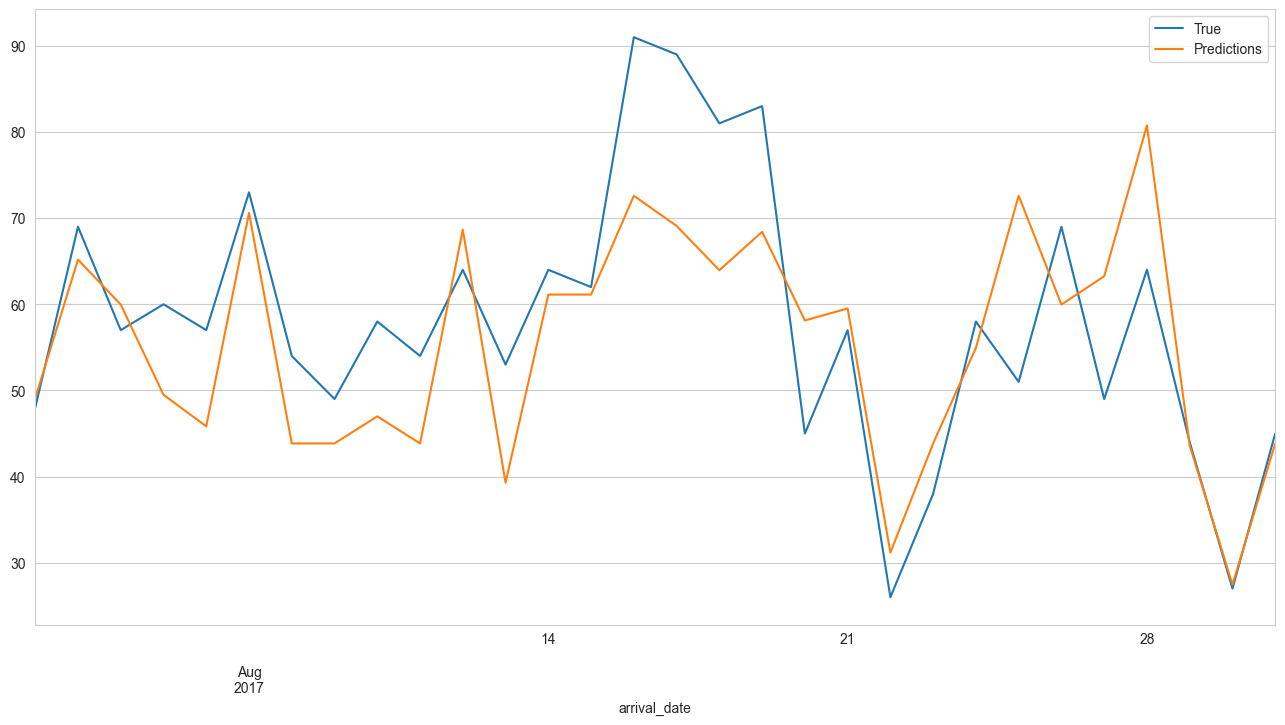

In [139]:
ax = best_preds_2_df['is_canceled'].plot(figsize=(16,8))
best_preds_2_df['prediction'].plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [140]:
print(regression_report(y_true=target_test, y_pred=best_preds_2))

MSE: 111.95660917190689
MAE: 8.460456720987956
RMSE: 10.580955021731587
MAPE: 0.14357483448779645
R2 Score: 0.5262076360225694


# SARIMAX - Seasonal Auto Regressive Integrated Moving Averages with eXogenous factors

In [78]:
time_data_smax = pd.concat([time_data_by_day.total_bookings, time_data_by_day_2], axis=1)

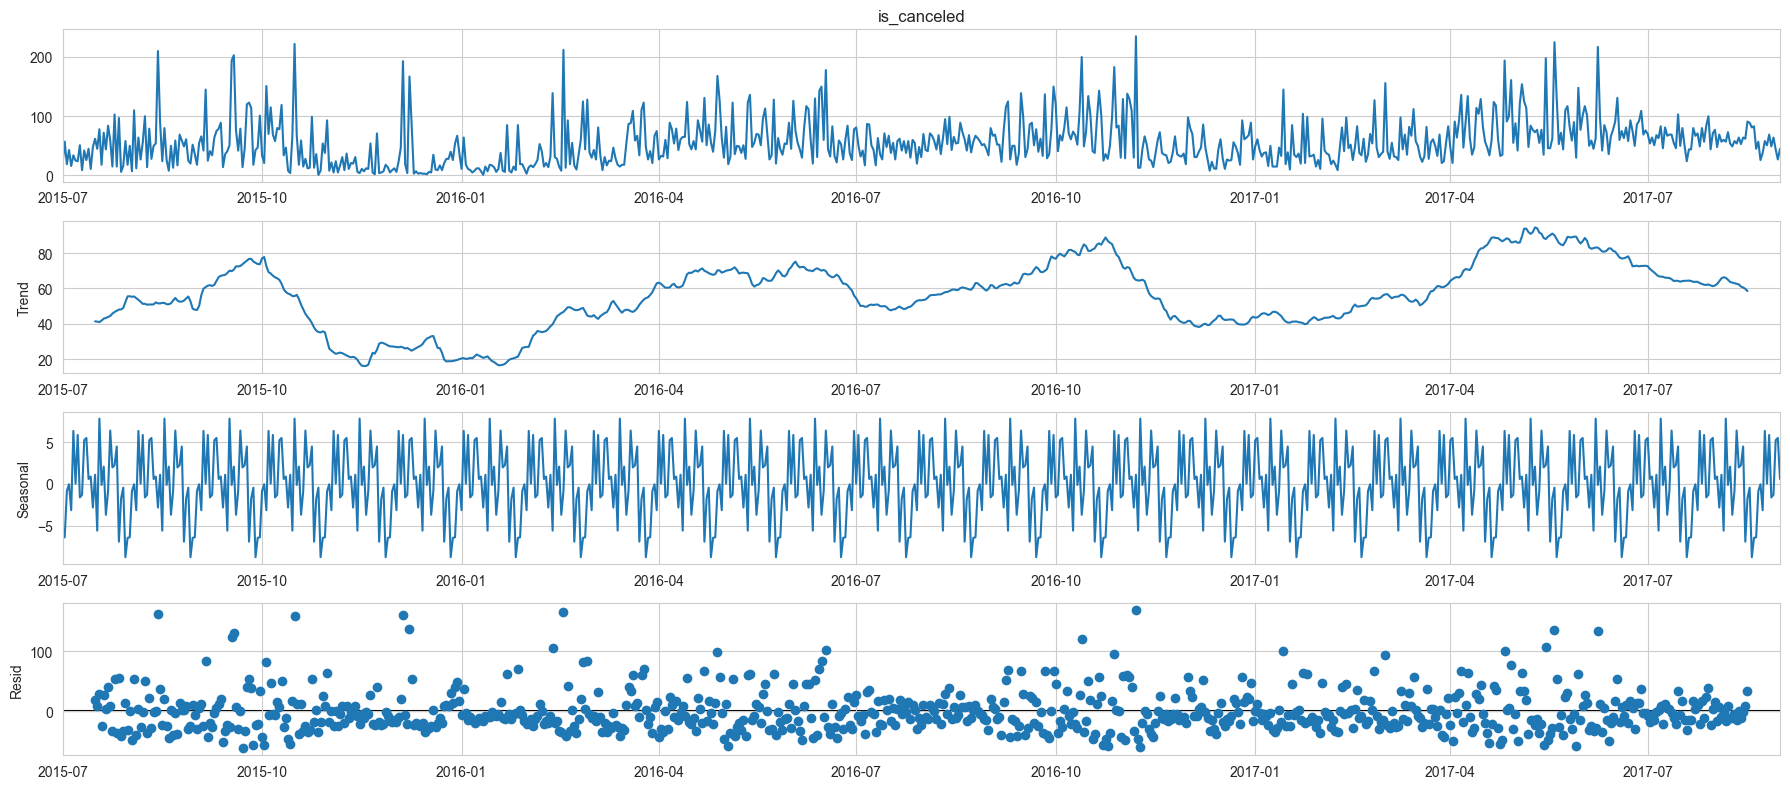

In [66]:
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(time_data_smax['is_canceled'], model = 'additive', period=30)
fig = decomposition.plot()
plt.show()

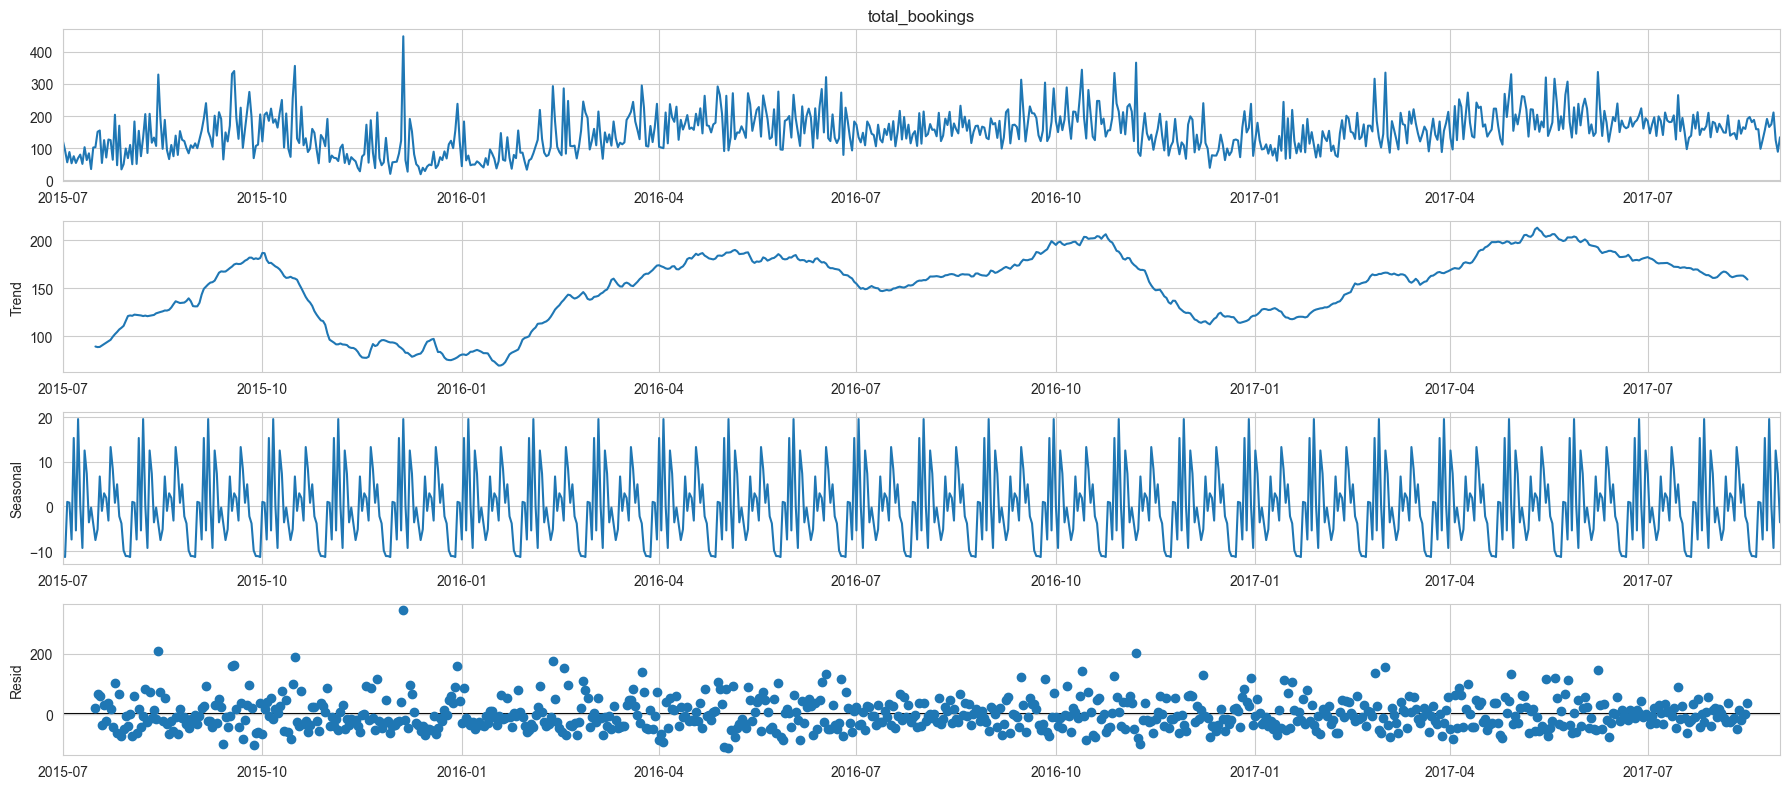

In [67]:
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(time_data_smax['total_bookings'], model = 'additive', period=30)
fig = decomposition.plot()
plt.show()

In [70]:
for name, column in time_data_smax[['is_canceled', 'total_bookings']].iteritems():
    Augmented_Dickey_Fuller_Test_func(time_data_smax[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: is_canceled
Test Statistic                  -2.586275
p-value                          0.095867
No Lags Used                    20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
dtype: float64
Test Statistic                  -2.586275
p-value                          0.095867
No Lags Used                    20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
Critical Value (5%)             -2.865291
dtype: float64
Test Statistic                  -2.586275
p-value                          0.095867
No Lags Used                    20.000000
Number of Observations Used    772.000000
Critical Value (1%)             -3.438849
Critical Value (5%)             -2.865291
Critical Value (10%)            -2.568767
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: total_bookings
Test Statis

In [79]:
# Differencing order 1
time_data_smax.is_canceled = time_data_smax.is_canceled.diff().fillna(0)
time_data_smax.head()

,total_bookings,is_canceled,lag1,lag2,lag3
arrival_date,,,,,
2015-07-01,122,0.0,0.0,0.0,0.0
2015-07-02,93,38.0,0.0,0.0,0.0
2015-07-03,56,-38.0,0.0,0.0,0.0
2015-07-04,88,24.0,0.0,0.0,0.0
2015-07-05,53,-27.0,0.0,0.0,0.0


In [80]:
# adf test again
Augmented_Dickey_Fuller_Test_func(time_data_smax['is_canceled'],'is_canceled')

Results of Dickey-Fuller Test for column: is_canceled
Test Statistic                -1.125800e+01
p-value                        1.648708e-20
No Lags Used                   1.900000e+01
Number of Observations Used    7.730000e+02
Critical Value (1%)           -3.438838e+00
dtype: float64
Test Statistic                -1.125800e+01
p-value                        1.648708e-20
No Lags Used                   1.900000e+01
Number of Observations Used    7.730000e+02
Critical Value (1%)           -3.438838e+00
Critical Value (5%)           -2.865286e+00
dtype: float64
Test Statistic                -1.125800e+01
p-value                        1.648708e-20
No Lags Used                   1.900000e+01
Number of Observations Used    7.730000e+02
Critical Value (1%)           -3.438838e+00
Critical Value (5%)           -2.865286e+00
Critical Value (10%)          -2.568765e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


### We now know that the value for differencing is 1

In [81]:
# Differencing order 1
time_data_smax.total_bookings = time_data_smax.total_bookings.diff().fillna(0)
time_data_smax.head()

,total_bookings,is_canceled,lag1,lag2,lag3
arrival_date,,,,,
2015-07-01,0.0,0.0,0.0,0.0,0.0
2015-07-02,-29.0,38.0,0.0,0.0,0.0
2015-07-03,-37.0,-38.0,0.0,0.0,0.0
2015-07-04,32.0,24.0,0.0,0.0,0.0
2015-07-05,-35.0,-27.0,0.0,0.0,0.0


In [82]:
# adf test again
Augmented_Dickey_Fuller_Test_func(time_data_smax['total_bookings'],'total_bookings')

Results of Dickey-Fuller Test for column: total_bookings
Test Statistic                -1.089744e+01
p-value                        1.182404e-19
No Lags Used                   1.900000e+01
Number of Observations Used    7.730000e+02
Critical Value (1%)           -3.438838e+00
dtype: float64
Test Statistic                -1.089744e+01
p-value                        1.182404e-19
No Lags Used                   1.900000e+01
Number of Observations Used    7.730000e+02
Critical Value (1%)           -3.438838e+00
Critical Value (5%)           -2.865286e+00
dtype: float64
Test Statistic                -1.089744e+01
p-value                        1.182404e-19
No Lags Used                   1.900000e+01
Number of Observations Used    7.730000e+02
Critical Value (1%)           -3.438838e+00
Critical Value (5%)           -2.865286e+00
Critical Value (10%)          -2.568765e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


#### The parameters for the integrated terms in SARIMAX are 1 for both seasonal and non seasonal

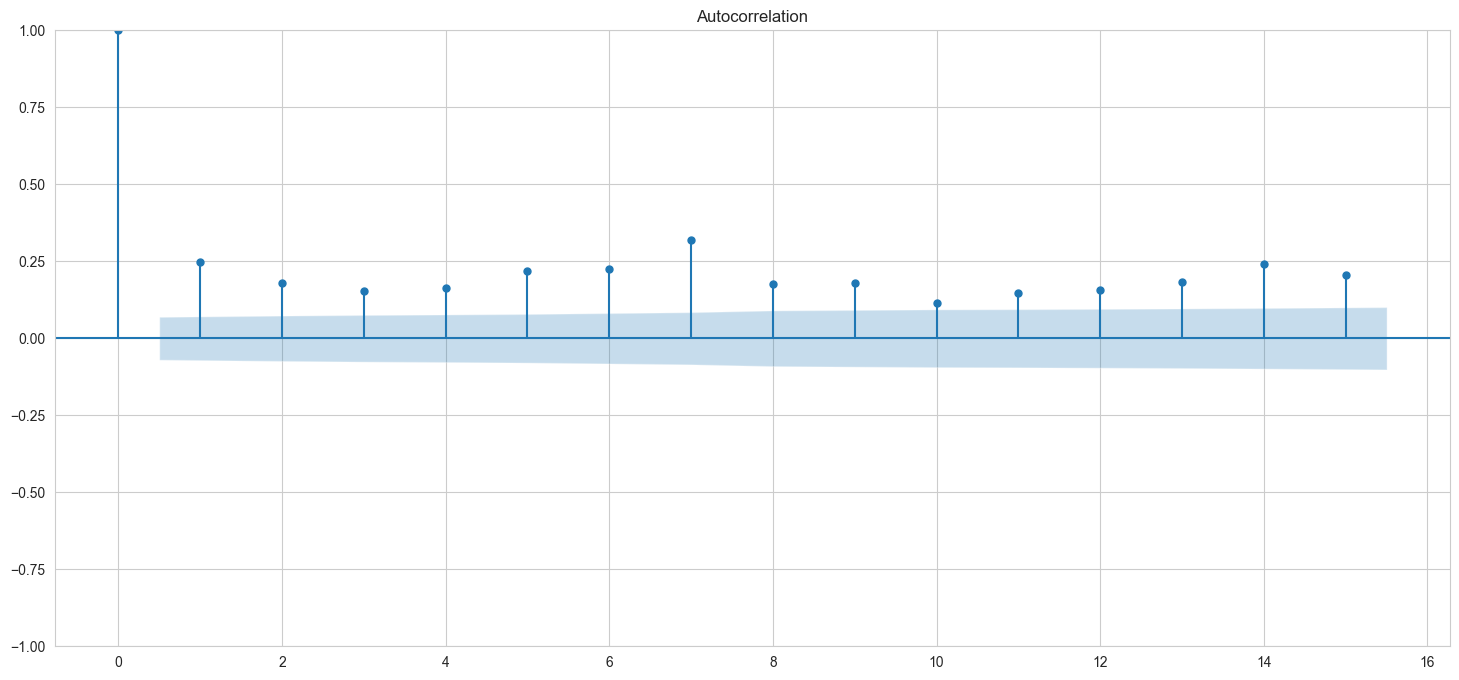

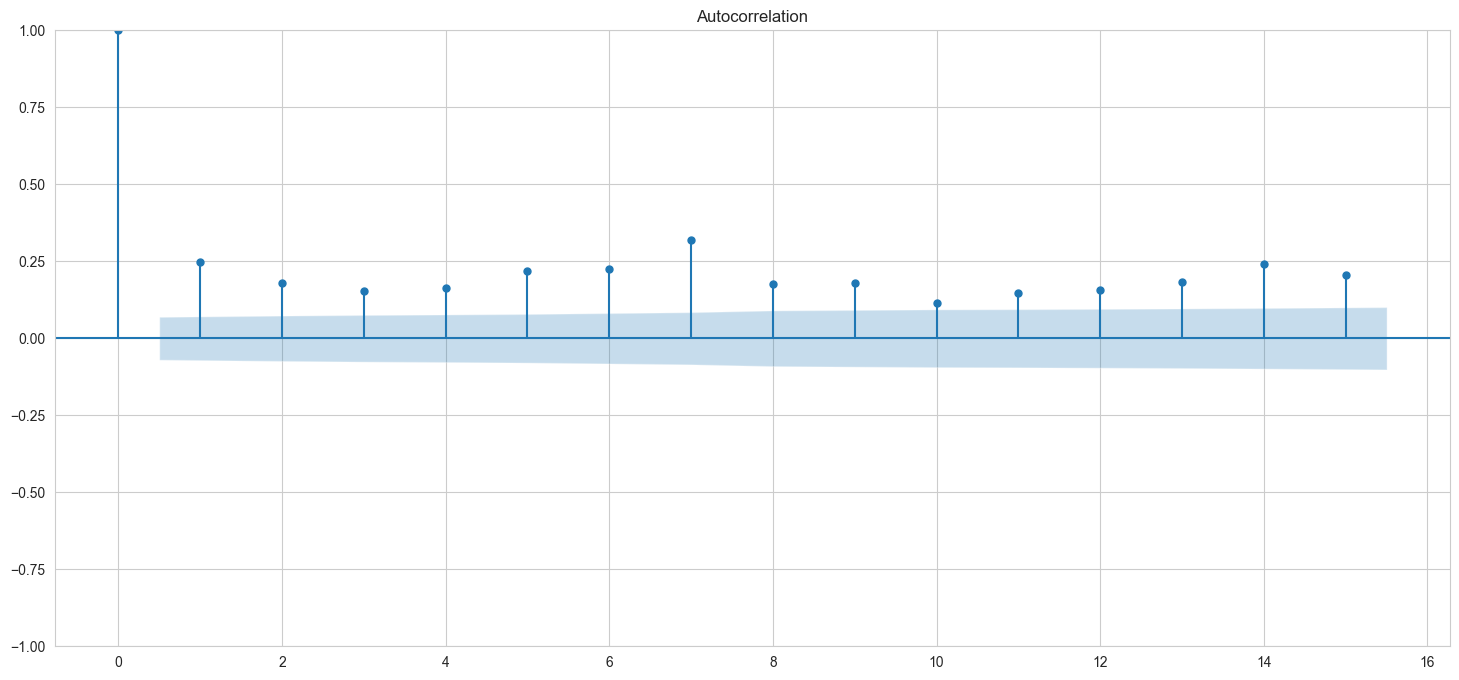

In [59]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(time_data_smax.is_canceled, lags = 15)

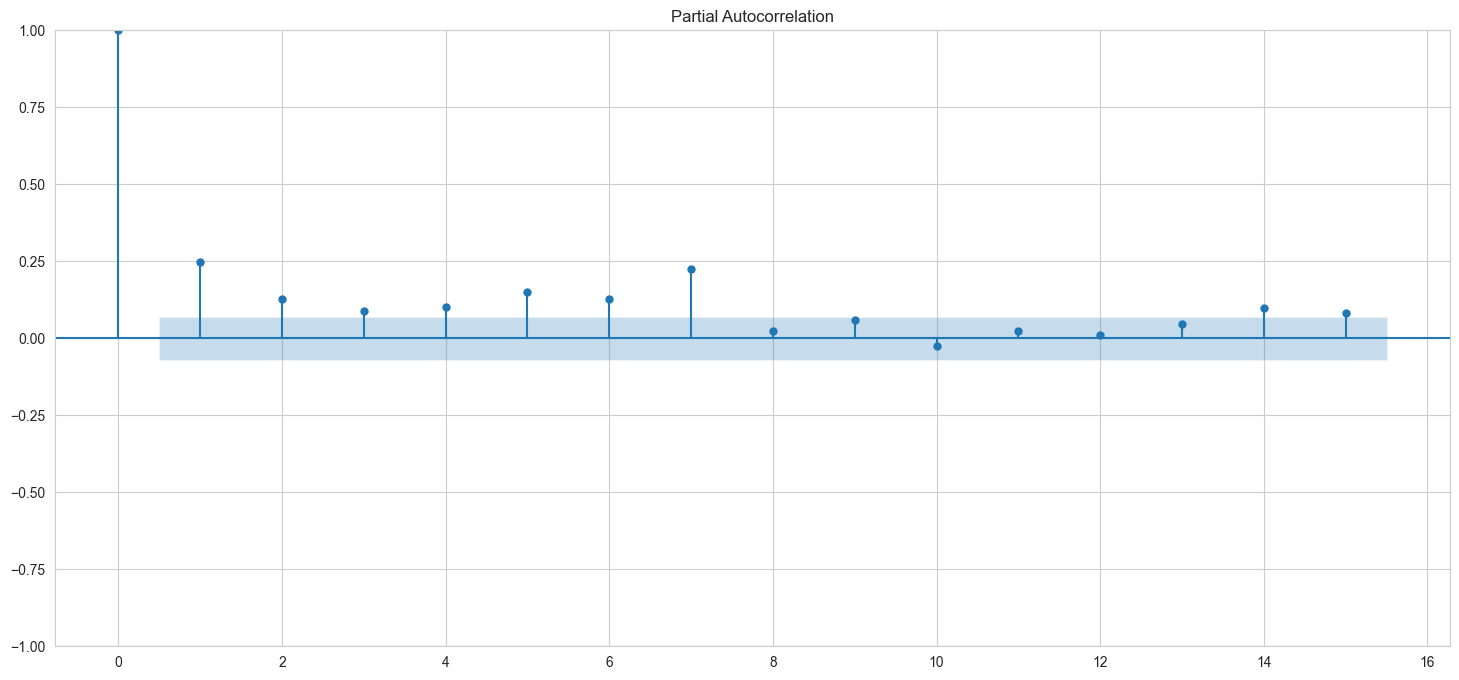

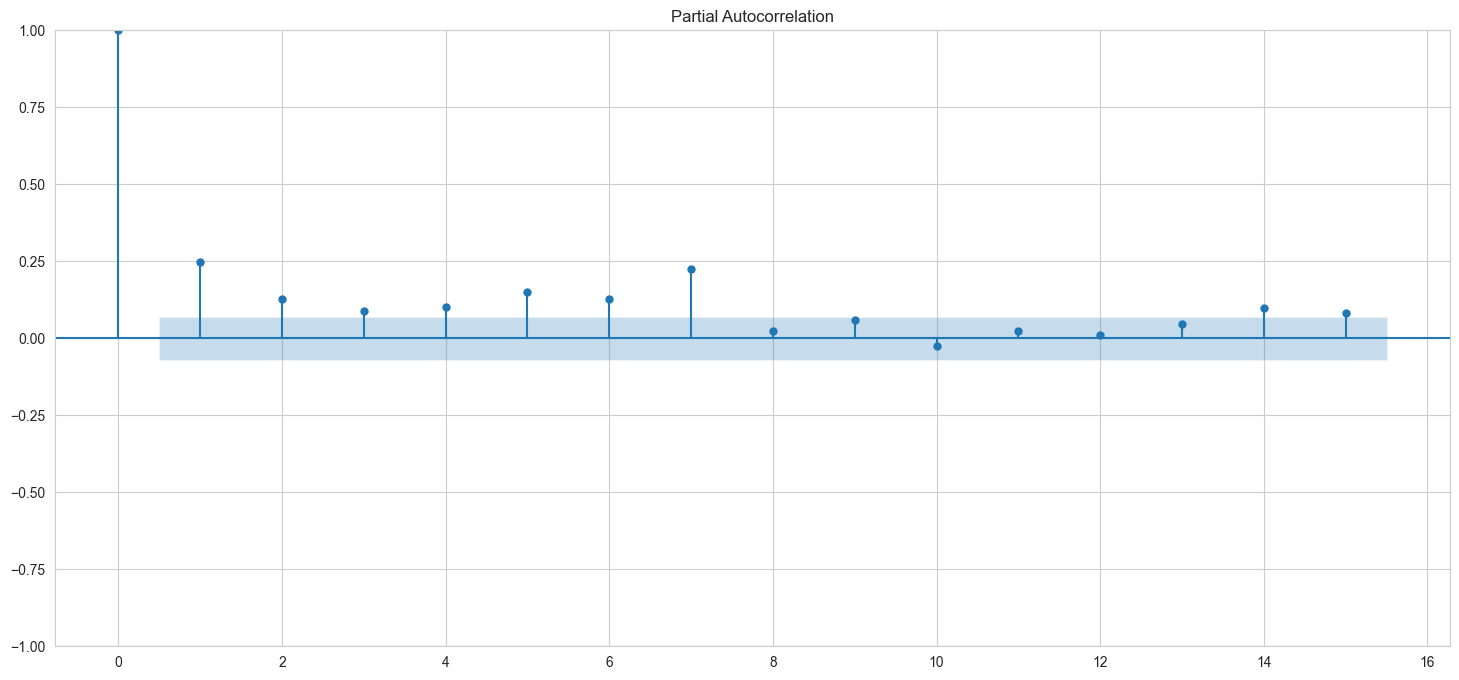

In [60]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(time_data_smax.is_canceled, lags = 15, method="OLS")

#### There is a clear inverse geometric trend in both the ACF and PACF plots

In [86]:
X = time_data_smax[['is_canceled' ]]
X_train, X_test = X[0:-30], X[-30:]
exoX = time_data_smax[['total_bookings' ]]
exotrain, exotest = exoX[0:-30], exoX[-30:]

In [148]:
for m in range(1, 13):
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(X_train,exogenous =exotrain ,
                                start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
                                start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m, d=None,D=None,
                                trace=True,error_action='ignore',suppress_warnings=True,
                                stepwise=True)
    print(f'Model summary for m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    forecast,conf_int = stepwise_model.predict(n_periods=30, exogenous =exotest,return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound', 'Lower_bound'])
    timeseries_evaluation_metrics_func(X_test, forecast)

 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6635.573, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7158.910, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6919.143, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6635.149, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7156.911, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=6635.552, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6637.405, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6633.646, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6634.030, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6634.007, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6917.147, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6635.833, Time=0.41 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 2.701 seconds
Model summary for m = 1
----------------------

#### The best RMSE for SARIMAX was with seasonality 10, with seasonal order 0, 0, 1 and seasonal order 0, 0, 2, 7

In [150]:
smax = SARIMAX(X_train, exog=exotrain, order=(0,0,1), seasonal_order=(0,0,2,7))
results = smax.fit()

In [151]:
forecast = results.get_forecast(steps=30, exog=exotest)
predicted = forecast.predicted_mean
ci = forecast.conf_int()

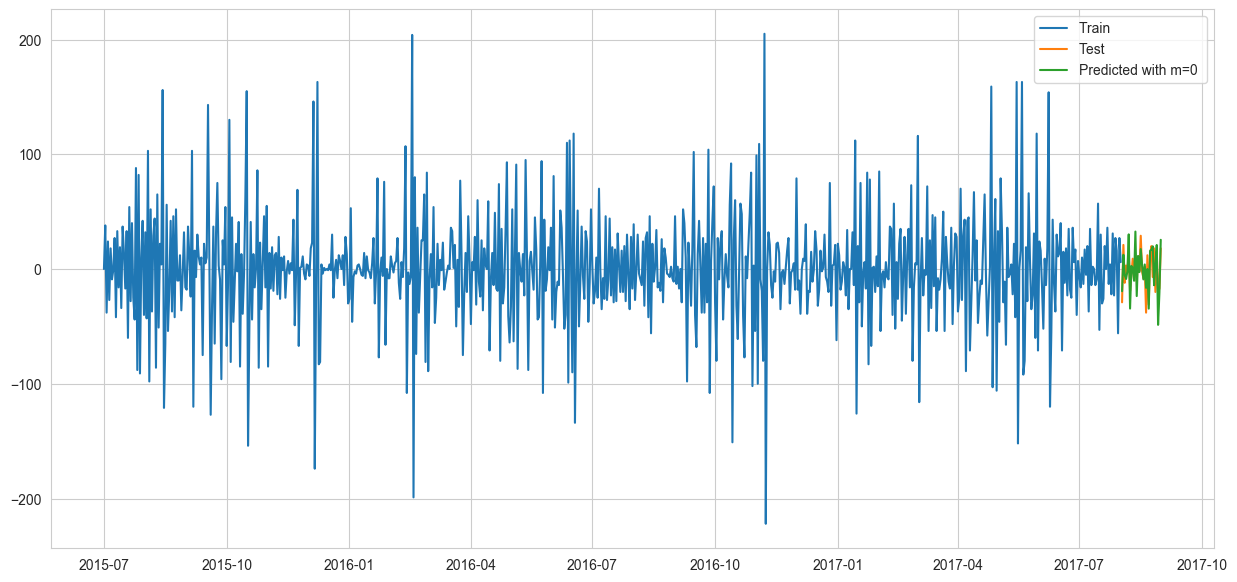

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 0


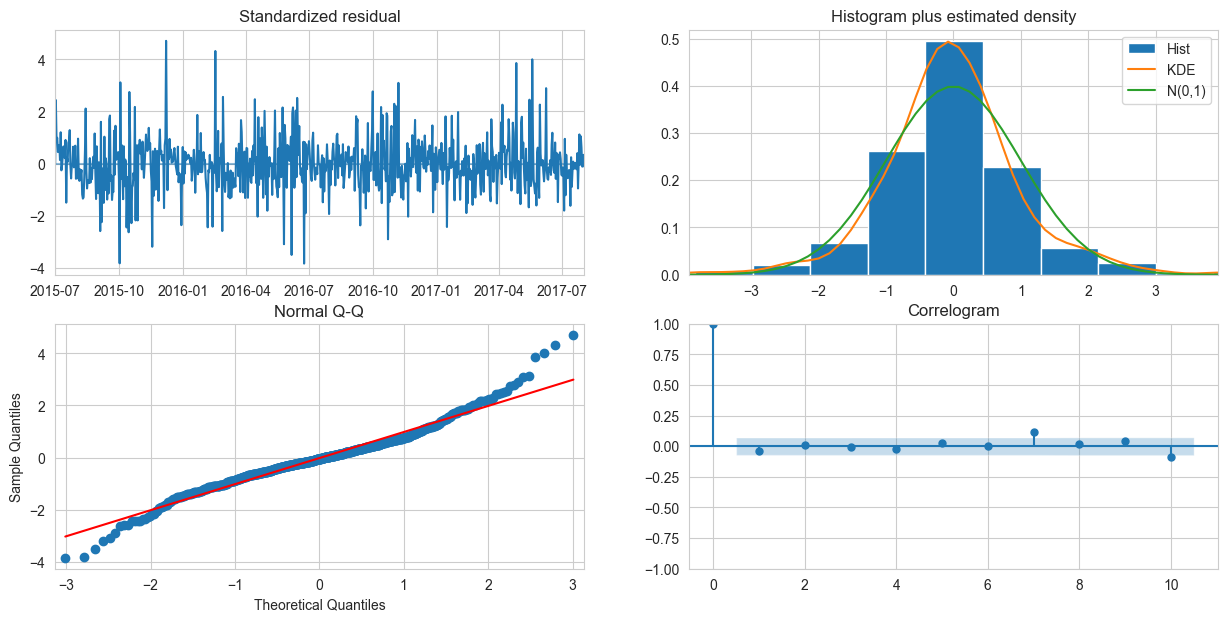

----------------------------------------------------------------------------------------------------


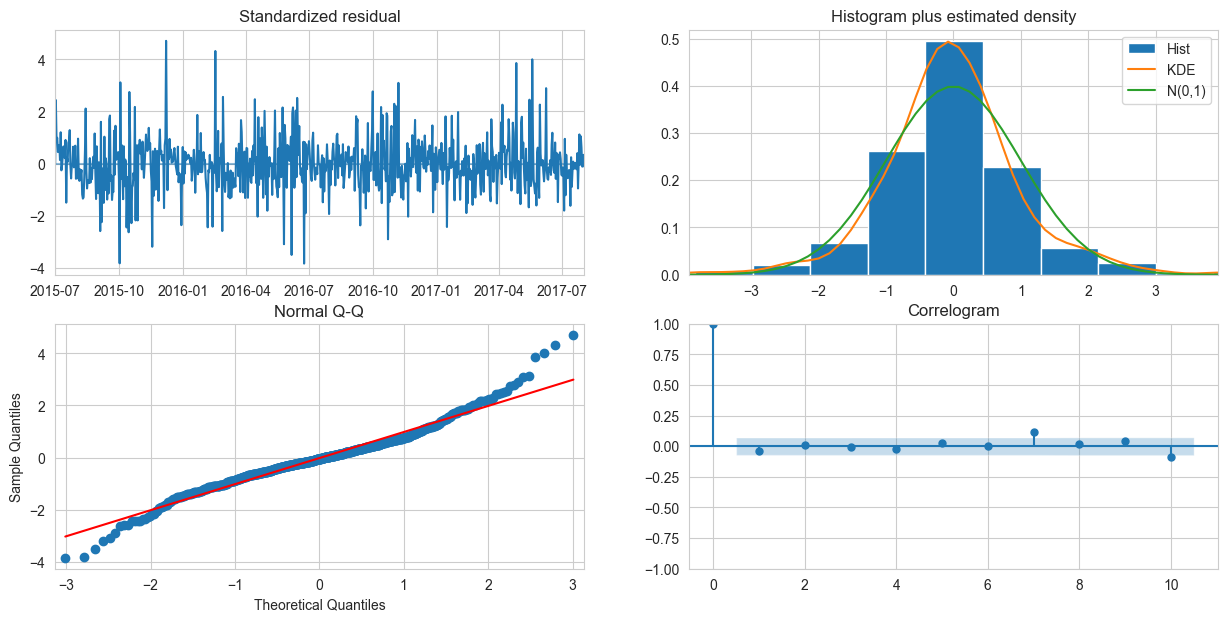

In [152]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(X_train, label='Train ')
plt.plot(X_test, label='Test ')
plt.plot(predicted, label=f'Predicted with m={str(m)} ')
plt.legend(loc='best')
plt.show()
print("-"*100)
print(f' Diagnostic plot for Seasonal value m = {str(m)}')
display(stepwise_model.plot_diagnostics())
print("-"*100)

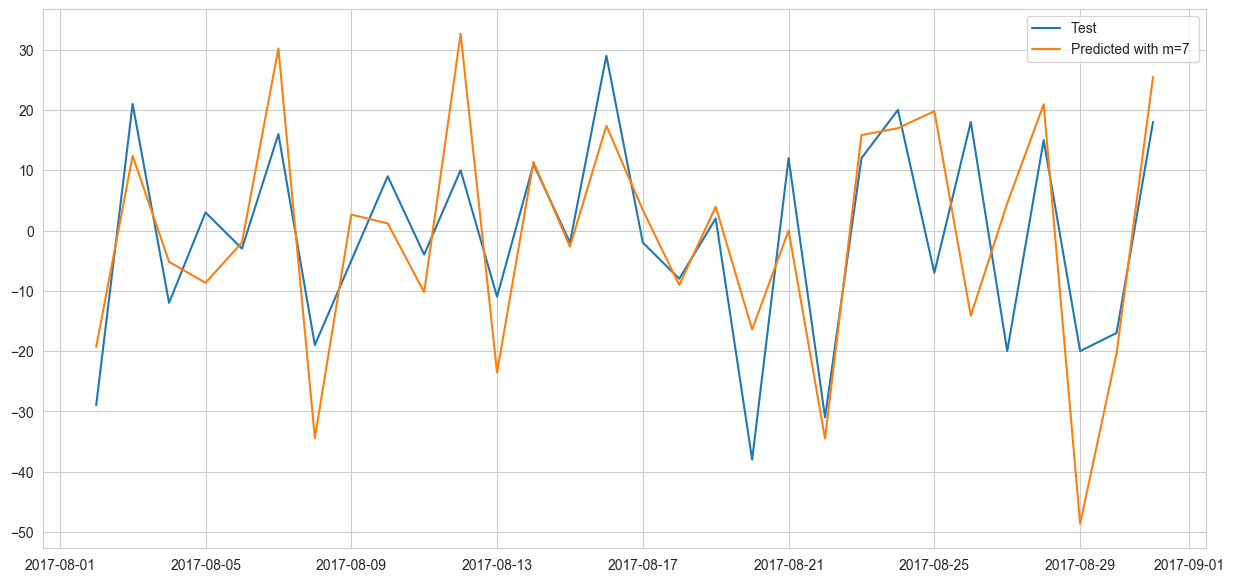

In [234]:
plt.plot(X_test, label='Test ')
plt.plot(predicted, label=f'Predicted with m={str(7)} ')
plt.legend()
plt.show()

In [142]:
print(regression_report(X_test, predicted))

MSE: 191.5636264141752
MAE: 10.601648361319118
RMSE: 13.840651227965221
MAPE: 0.9873469501599189
R2 Score: 0.32483566560896293


# SARIMAX with time lags

In [145]:
X_2 = time_data_by_day_2[['is_canceled' ]]
X_train_2, X_test_2 = X_2[0:-30], X_2[-30:]
exoX_2 = time_data_by_day_2.drop('is_canceled', axis=1)
exotrain_2, exotest_2 = exoX_2[0:-30], exoX_2[-30:]

In [154]:
for m in range(1, 13):
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(X_train_2,exogenous =exotrain_2 ,
                                start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
                                start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m, d=None,D=None,
                                trace=True,error_action='ignore',suppress_warnings=True,
                                stepwise=True)
    print(f'Model summary for m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    forecast,conf_int = stepwise_model.predict(n_periods=30, exogenous =exotest_2,return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound', 'Lower_bound'])
    timeseries_evaluation_metrics_func(X_test_2, forecast)

 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6627.217, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7151.463, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6910.279, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6627.534, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7149.465, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6629.167, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6629.063, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6627.179, Time=0.53 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6629.138, Time=0.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6625.050, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6628.418, Time=1.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6627.045, Time=1.15 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=6630.851, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6625.103, Time=

#### Best results are for seasonality 7 with order 0 1 1 and seasonal order 1 0 2 7

In [155]:
smax_2 = SARIMAX(X_train_2, exog=exotrain_2, order=(0,1,1), seasonal_order=(1,0,2,7))
results_2 = smax_2.fit()

In [157]:
forecast_2 = results_2.get_forecast(steps=30, exog=exotest_2)
predicted_2 = forecast_2.predicted_mean
ci_2 = forecast_2.conf_int()

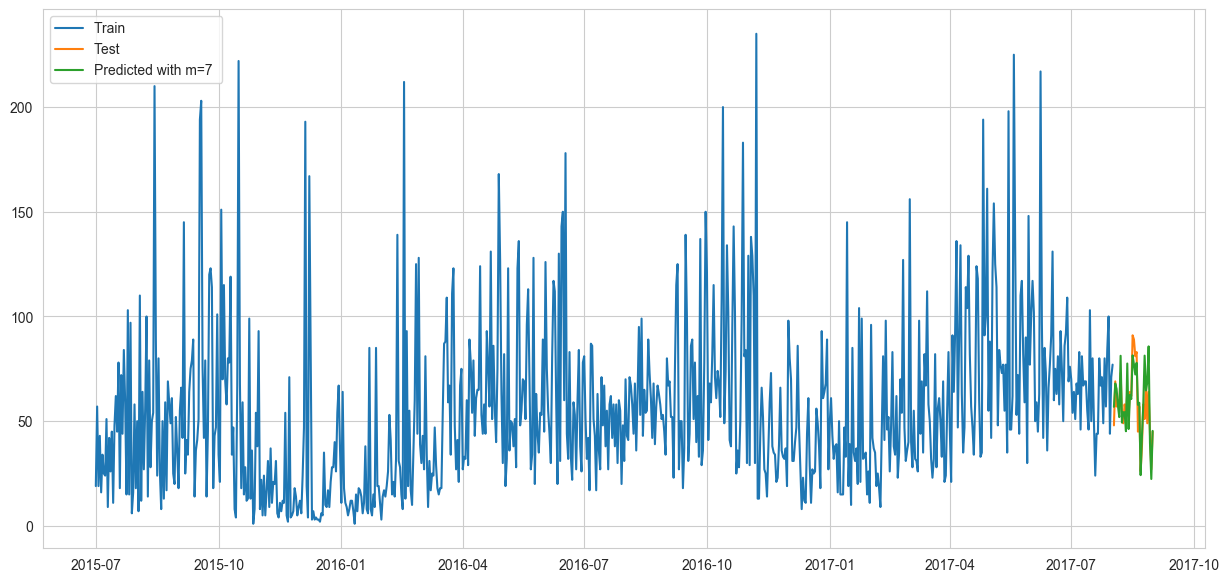

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 7


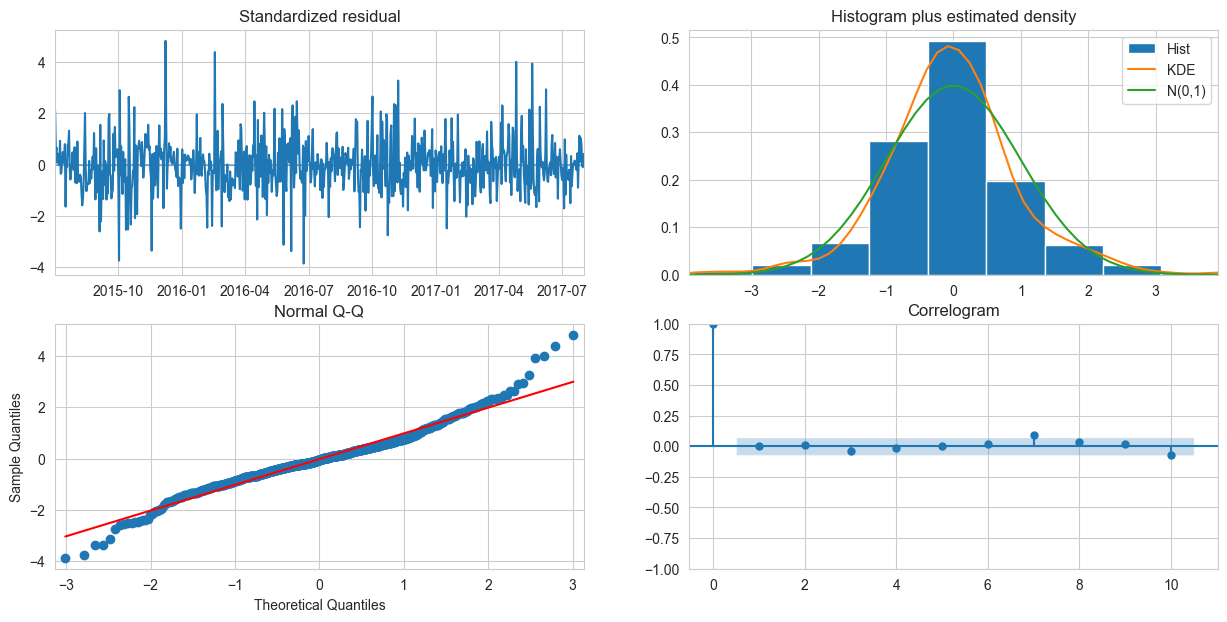

----------------------------------------------------------------------------------------------------


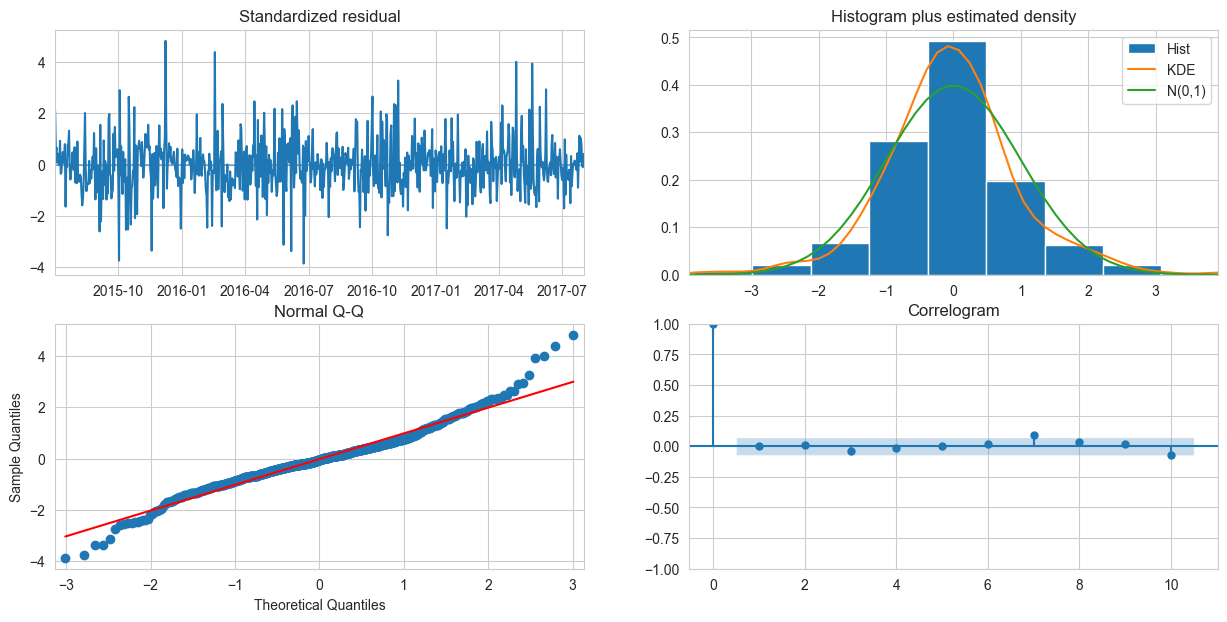

In [158]:
import matplotlib.pyplot as plt
m = 7
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(X_train_2, label='Train ')
plt.plot(X_test_2, label='Test ')
plt.plot(predicted_2, label=f'Predicted with m={str(m)} ')
plt.legend(loc='best')
plt.show()
print("-"*100)
print(f' Diagnostic plot for Seasonal value m = {str(m)}')
display(stepwise_model.plot_diagnostics())
print("-"*100)

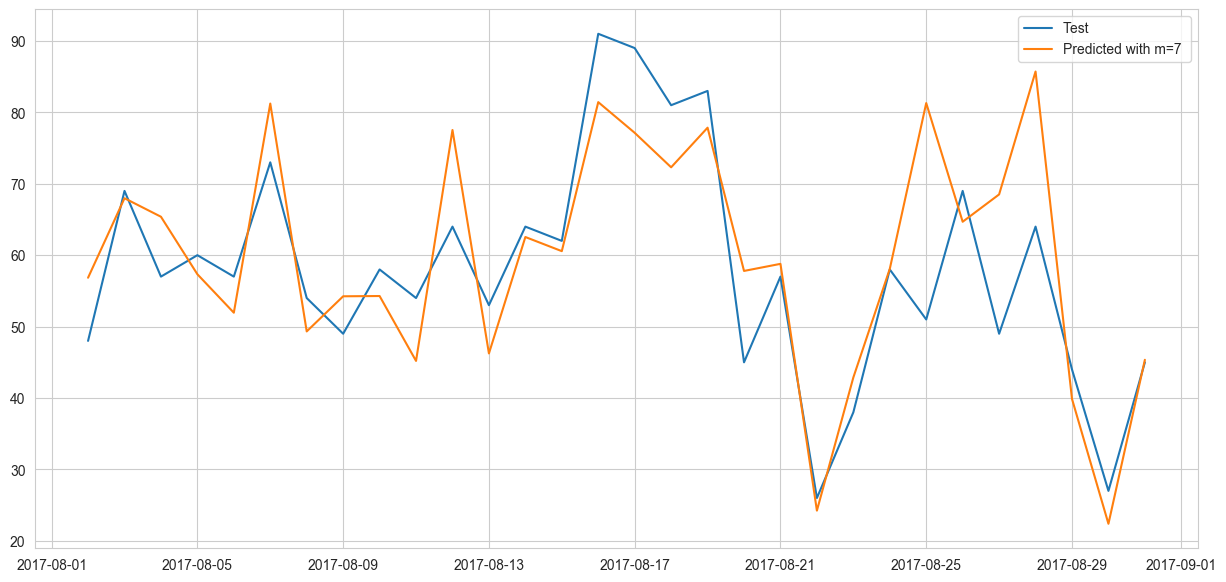

In [159]:
plt.plot(X_test_2, label='Test ')
plt.plot(predicted_2, label=f'Predicted with m={str(m)} ')
plt.legend()
plt.show()

In [235]:
print(regression_report(X_test_2, predicted_2))

MSE: 99.29458421822237
MAE: 7.378017637250283
RMSE: 9.96466678912157
MAPE: 0.1328407408067336
R2 Score: 0.5797924201627876


#### Since SARIMAX outperformed the XGBoost Regressor, we use SARIMAX for the following
* Forecast bookings
* Compare with actual
* Forecast Cancellations using forecasted bookings
* Compare with actual

In [178]:
# forecasting bookings
booking_data = time_data_by_day_2.drop(['is_canceled', 'lag1', 'lag2', 'lag3'], axis=1).copy()
booking_data.index = pd.to_datetime(booking_data.index)
booking_data = booking_data.sort_index()
booking_data.head()

,total_bookings
arrival_date,
2015-07-01,122
2015-07-02,93
2015-07-03,56
2015-07-04,88
2015-07-05,53


In [179]:
# create features
booking_data_augmented = create_feature(booking_data)
booking_data_augmented.head()

,total_bookings,day_of_month,month,year,day_of_year
arrival_date,,,,,
2015-07-01,122,1,7,2015,182
2015-07-02,93,2,7,2015,183
2015-07-03,56,3,7,2015,184
2015-07-04,88,4,7,2015,185
2015-07-05,53,5,7,2015,186


In [180]:
booking_data_augmented_lagged = create_lag(booking_data_augmented, 'total_bookings', 30)
booking_data_augmented_lagged.head()

,total_bookings,day_of_month,month,year,day_of_year,lag1,lag2,lag3
arrival_date,,,,,,,,
2015-07-01,122,1,7,2015,182,0.0,0.0,0.0
2015-07-02,93,2,7,2015,183,0.0,0.0,0.0
2015-07-03,56,3,7,2015,184,0.0,0.0,0.0
2015-07-04,88,4,7,2015,185,0.0,0.0,0.0
2015-07-05,53,5,7,2015,186,0.0,0.0,0.0


In [181]:
X_3 = booking_data_augmented_lagged[['total_bookings' ]]
X_train_3, X_test_3 = X_3[0:-30], X_3[-30:]
exoX_3 = booking_data_augmented_lagged.drop('total_bookings', axis=1)
exotrain_3, exotest_3 = exoX_3[0:-30], exoX_3[-30:]

In [182]:
for m in range(1, 13):
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(X_train_3,exogenous =exotrain_3,
                                start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
                                start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m, d=None,D=None,
                                trace=True,error_action='ignore',suppress_warnings=True,
                                stepwise=True)
    print(f'Model summary for m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    forecast,conf_int = stepwise_model.predict(n_periods=30, exogenous=exotest_3,return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound', 'Lower_bound'])
    timeseries_evaluation_metrics_func(X_test_3, forecast)

 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8299.626, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8477.417, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8426.669, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8441.343, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8475.417, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8304.659, Time=1.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8301.036, Time=1.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8427.615, Time=0.96 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8401.300, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8297.920, Time=1.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8298.478, Time=1.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8299.369, Time=1.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8301.224, Time=1.66 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8304.505, Time=

#### Best results are for seasonality 2 with order 1 0 1 and seasonal order 7 0 0 2 2812

In [188]:
smax_3 = SARIMAX(X_train_3, exog=exotrain_3, order=(1,0,1), seasonal_order=(7,0,0,2))
results_3 = smax_3.fit()

In [189]:
forecast_3 = results_3.get_forecast(steps=30, exog=exotest_3)
predicted_3 = forecast_3.predicted_mean
ci_3 = forecast_3.conf_int()

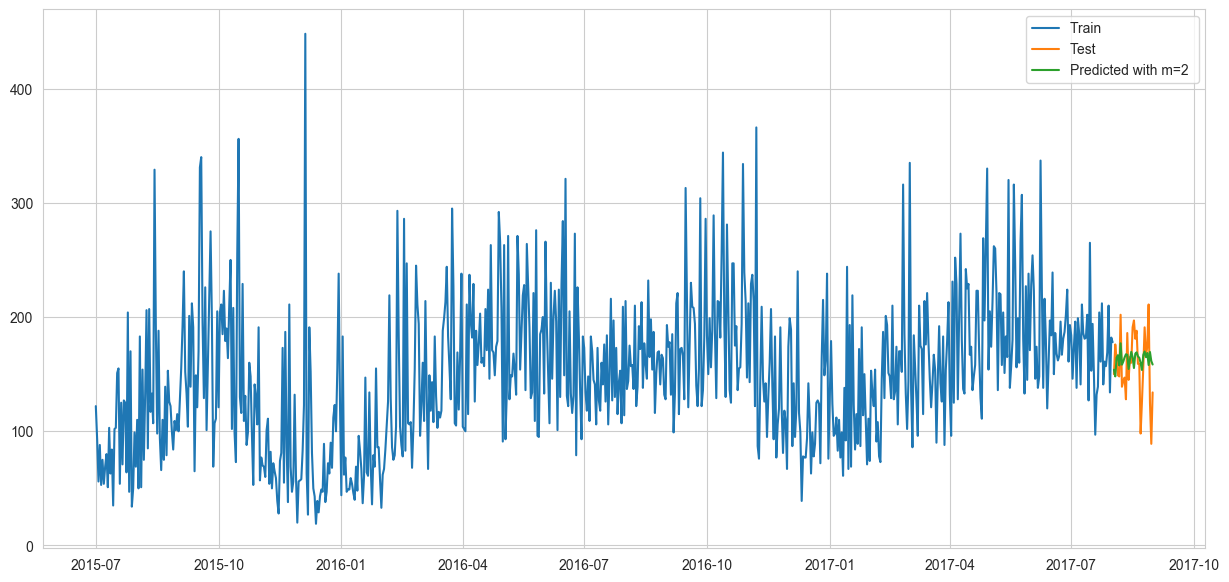

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 2


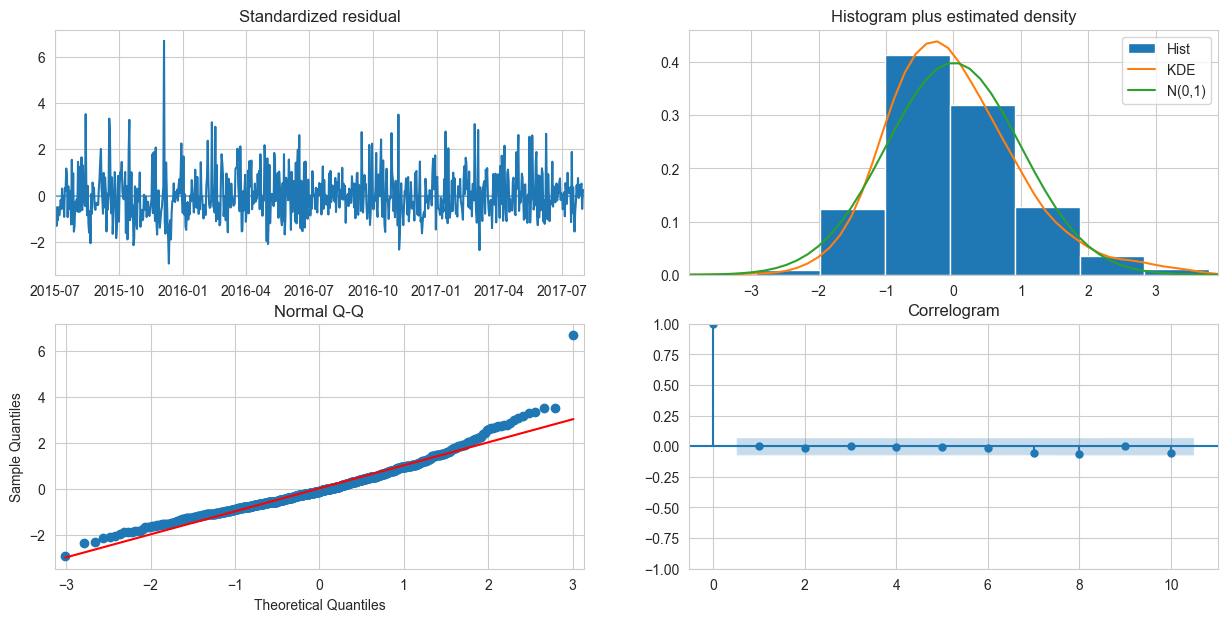

----------------------------------------------------------------------------------------------------


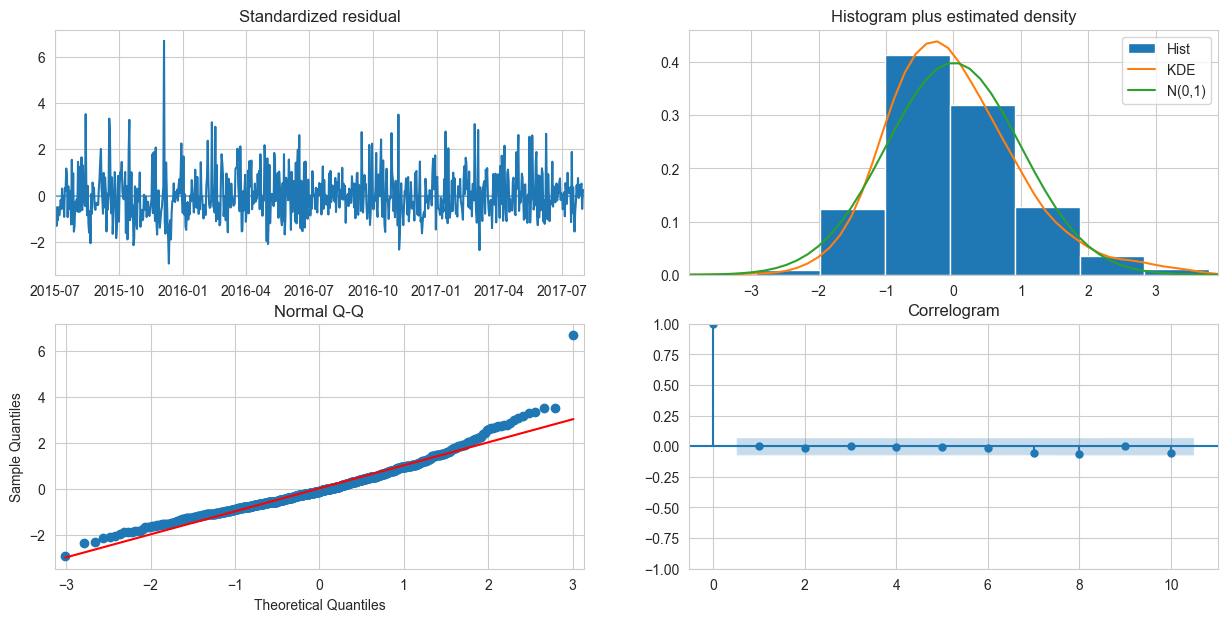

In [192]:
import matplotlib.pyplot as plt
m = 2
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(X_train_3, label='Train ')
plt.plot(X_test_3, label='Test ')
plt.plot(predicted_3, label=f'Predicted with m={str(m)} ')
plt.legend(loc='best')
plt.show()
print("-"*100)
print(f' Diagnostic plot for Seasonal value m = {str(m)}')
display(stepwise_model.plot_diagnostics())
print("-"*100)

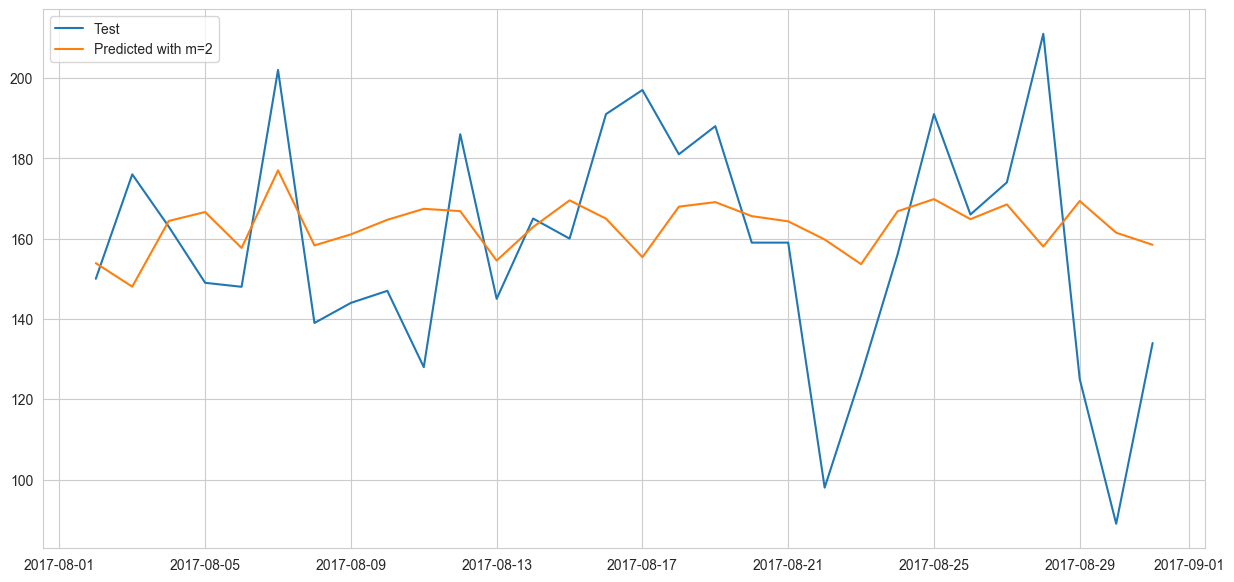

In [193]:
plt.plot(X_test_3, label='Test ')
plt.plot(predicted_3, label=f'Predicted with m={str(m)}')
plt.legend()
plt.show()

In [237]:
print(regression_report(X_test_3, predicted_3))

MSE: 790.7782380727003
MAE: 21.7720258919736
RMSE: 28.120779471286003
MAPE: 0.15645805893420742
R2 Score: 0.028741411912710513


#### Our results for our forecasted bookings show that predicting bookings then predicting cancellations based on this is a possible way to set a number of cancellations and overbookings availalble for the next month

In [194]:
# forecasting is_canceled using predicted bookings
canceled_with_forecasts = time_data_by_day_2.drop(['total_bookings', 'lag1', 'lag2', 'lag3'], axis=1).copy()
canceled_with_forecasts['total_bookings'] = predicted_3
canceled_with_forecasts.index = pd.to_datetime(canceled_with_forecasts.index)
canceled_with_forecasts = canceled_with_forecasts.sort_index()
canceled_with_forecasts.head()

,is_canceled,total_bookings
arrival_date,,
2015-07-01,19,NaN
2015-07-02,57,NaN
2015-07-03,19,NaN
2015-07-04,43,NaN
2015-07-05,16,NaN


In [195]:
# create features
canceled_with_forecasts_augmented = create_feature(canceled_with_forecasts)
canceled_with_forecasts_augmented.head()

,is_canceled,total_bookings,day_of_month,month,year,day_of_year
arrival_date,,,,,,
2015-07-01,19,NaN,1,7,2015,182
2015-07-02,57,NaN,2,7,2015,183
2015-07-03,19,NaN,3,7,2015,184
2015-07-04,43,NaN,4,7,2015,185
2015-07-05,16,NaN,5,7,2015,186


In [196]:
canceled_with_forecasts_augmented_lagged = create_lag(canceled_with_forecasts_augmented, 'is_canceled', 30)
canceled_with_forecasts_augmented_lagged.head()

,is_canceled,total_bookings,day_of_month,month,year,day_of_year,lag1,lag2,lag3
arrival_date,,,,,,,,,
2015-07-01,19,0.0,1,7,2015,182,0.0,0.0,0.0
2015-07-02,57,0.0,2,7,2015,183,0.0,0.0,0.0
2015-07-03,19,0.0,3,7,2015,184,0.0,0.0,0.0
2015-07-04,43,0.0,4,7,2015,185,0.0,0.0,0.0
2015-07-05,16,0.0,5,7,2015,186,0.0,0.0,0.0


In [197]:
X_4 = canceled_with_forecasts_augmented_lagged[['is_canceled' ]]
X_train_4, X_test_4 = X_4[0:-30], X_4[-30:]
exoX_4 = canceled_with_forecasts_augmented_lagged.drop('is_canceled', axis=1)
exotrain_4, exotest_4 = exoX_4[0:-30], exoX_4[-30:]

In [ ]:
for m in range(1, 13):
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(X_train_4,exogenous =exotrain_4,
                                start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
                                start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m, d=None,D=None,
                                trace=True,error_action='ignore',suppress_warnings=True,
                                stepwise=True)
    print(f'Model summary for m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    forecast,conf_int = stepwise_model.predict(n_periods=30, exogenous=exotest_4,return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound', 'Lower_bound'])
    timeseries_evaluation_metrics_func(X_test_4, forecast)

 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8299.626, Time=1.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8477.417, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8426.669, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8441.343, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8475.417, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8304.659, Time=1.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8301.036, Time=1.12 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8427.615, Time=0.96 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=8401.300, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8297.920, Time=1.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8298.478, Time=1.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8299.369, Time=1.39 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8301.224, Time=1.66 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8304.505, Time=

#### Best results are for seasonality 7 with order 0 1 1 and seasonal order 1 0 2 7

In [198]:
smax_4 = SARIMAX(X_train_4, exog=exotrain_4, order=(0,1,1), seasonal_order=(1,0,2,7))
results_4 = smax_4.fit()

In [199]:
forecast_4 = results_4.get_forecast(steps=30, exog=exotest_4)
predicted_4 = forecast_4.predicted_mean
ci_4 = forecast_4.conf_int()

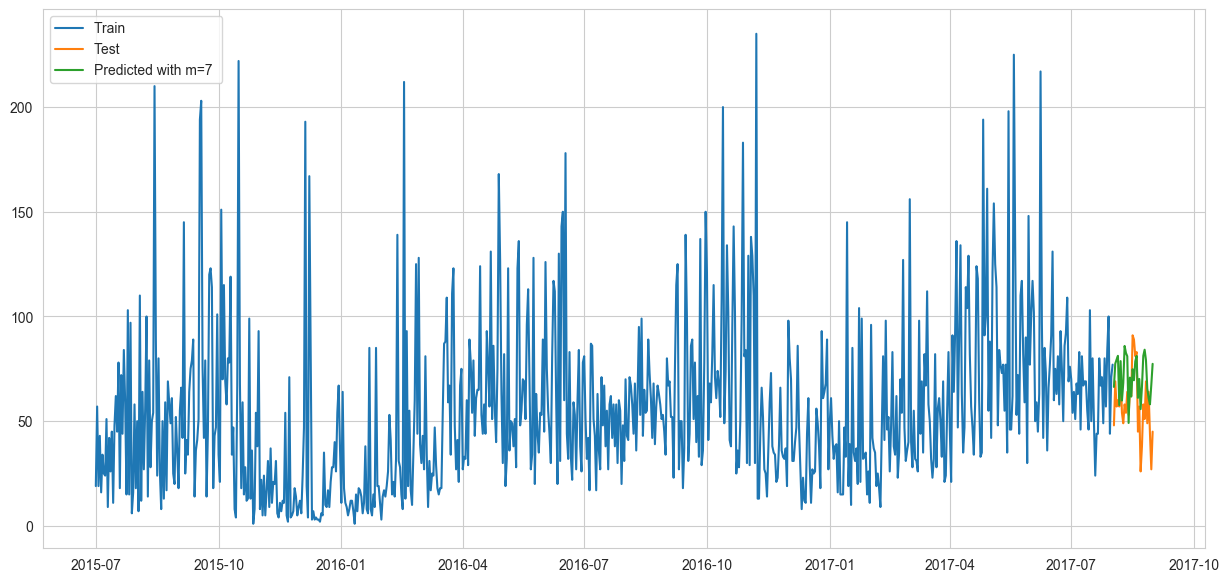

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 7


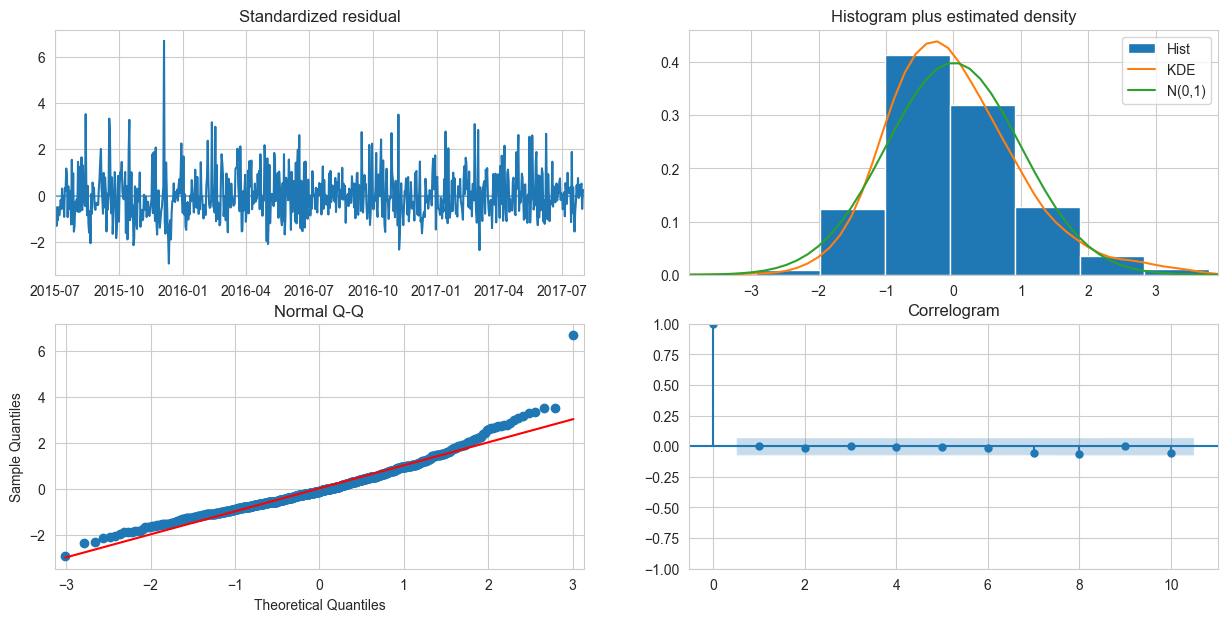

----------------------------------------------------------------------------------------------------


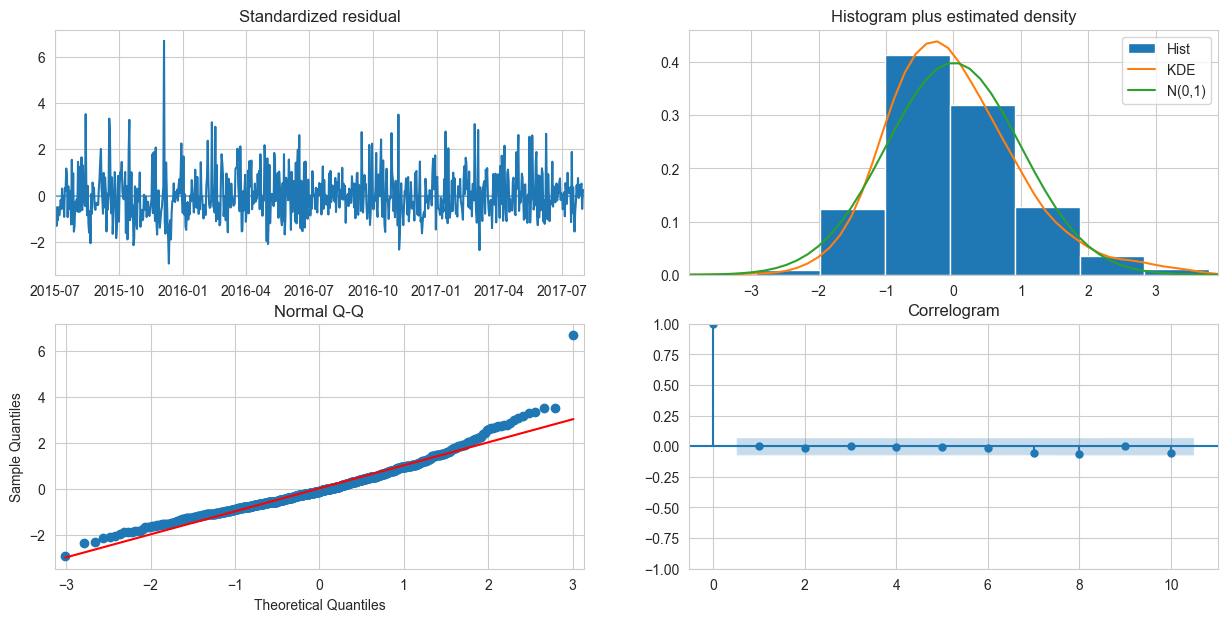

In [200]:
import matplotlib.pyplot as plt
m = 7
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15, 7]
plt.plot(X_train_4, label='Train ')
plt.plot(X_test_4, label='Test ')
plt.plot(predicted_4, label=f'Predicted with m={str(m)} ')
plt.legend(loc='best')
plt.show()
print("-"*100)
print(f' Diagnostic plot for Seasonal value m = {str(m)}')
display(stepwise_model.plot_diagnostics())
print("-"*100)

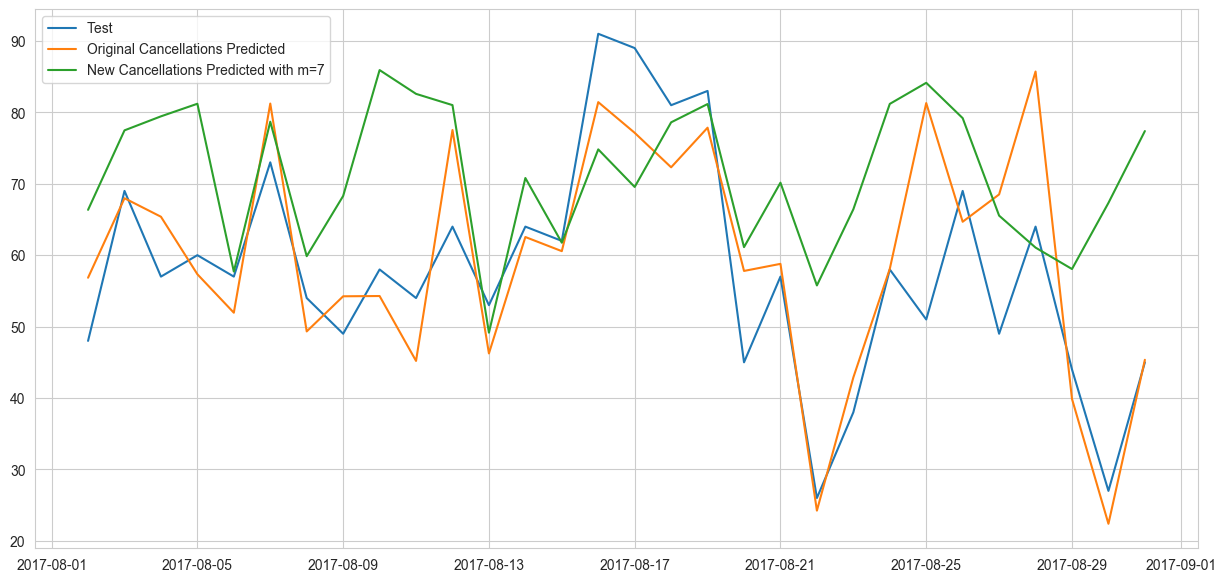

In [202]:
plt.plot(X_test_4, label='Test ')
plt.plot(predicted_2, label=f'Original Cancellations Predicted')
plt.plot(predicted_4, label=f'New Cancellations Predicted with m={str(m)}')
plt.legend()
plt.show()

In [204]:
print(regression_report(predicted_4, X_test_4))

MSE: 380.5869049646183
MAE: 16.21740535033023
RMSE: 19.50863667621647
MAPE: 0.2261440512603701
R2 Score: -3.0079879204870883


In [207]:
np.sum(time_data_by_day_2.is_canceled[-30:])

1739

In [208]:
np.sum(time_data_by_day_2.total_bookings[-30:])

4747

In [210]:
np.sum(predicted_4)

2131.690294890126

In [212]:
np.sum(predicted_3)

4890.910209662813

In [211]:
np.sum(predicted_2)

1788.949086131038

In [229]:
predictions = pd.concat([pd.DataFrame(np.array(predicted_3), columns=['total_bookings']),
                         pd.DataFrame(np.array(predicted_4), columns=['is_canceled'])], axis=1)
predictions.head(10)

,total_bookings,is_canceled
0,153.888458,66.348045
1,148.045844,77.477935
2,164.394585,79.440188
3,166.620491,81.203072
4,157.683534,57.706869
5,176.989836,78.688116
6,158.312601,59.860346
7,161.052236,68.290970
8,164.690211,85.918359
9,167.417526,82.587261


In [231]:
predictions.index = X_test_4.index

In [232]:
predictions.head(10)

,total_bookings,is_canceled
arrival_date,,
2017-08-02,153.888458,66.348045
2017-08-03,148.045844,77.477935
2017-08-04,164.394585,79.440188
2017-08-05,166.620491,81.203072
2017-08-06,157.683534,57.706869
2017-08-07,176.989836,78.688116
2017-08-08,158.312601,59.860346
2017-08-09,161.052236,68.290970
2017-08-10,164.690211,85.918359


In [292]:
predictions.to_csv('predictions.csv', index=True)

In [228]:
ic = pd.DataFrame(np.array(predicted_4))
ic

,0
0,66.348045
1,77.477935
2,79.440188
3,81.203072
4,57.706869
5,78.688116
6,59.860346
7,68.290970
8,85.918359
9,82.587261


In [222]:
predicted_3

2017-08-02    153.888458
2017-08-03    148.045844
2017-08-04    164.394585
2017-08-05    166.620491
2017-08-06    157.683534
2017-08-07    176.989836
2017-08-08    158.312601
2017-08-09    161.052236
2017-08-10    164.690211
2017-08-11    167.417526
2017-08-12    166.846016
2017-08-13    154.535700
2017-08-14    162.886372
2017-08-15    169.523491
2017-08-16    164.974931
2017-08-17    155.378317
2017-08-18    167.955272
2017-08-19    169.085932
2017-08-20    165.596274
2017-08-21    164.302062
2017-08-22    159.787572
2017-08-23    153.642855
2017-08-24    166.796508
2017-08-25    169.834192
2017-08-26    164.842761
2017-08-27    168.514065
2017-08-28    158.021178
2017-08-29    169.366019
2017-08-30    161.465747
2017-08-31    158.459622
Freq: D, Name: predicted_mean, dtype: float64

In [301]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                            is_canceled   No. Observations:                  763
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -3308.666
Date:                                Sun, 02 Apr 2023   AIC                           6627.332
Time:                                        22:12:54   BIC                           6650.518
Sample:                                    07-01-2015   HQIC                          6636.259
                                         - 08-01-2017                                         
Covariance Type:                                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
total_bookings     0.5657      0.009     65.818      0.000       0.549       0.583
ma.L1             -0.9676      0.009   -105.008      0.000      -0.986      -0.950
ma.S.L7            0.1163      0.038      3.095      0.002       0.043       0.190
ma.S.L14           0.0256      0.038      0.680      0.496      -0.048       0.099
sigma2           340.8446     12.135     28.087      0.000     317.060     364.629
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):               217.08
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.29
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [278]:
data_new = pd.read_csv('hotel_bookings.csv')
data_new = data_new.fillna(0)

In [279]:
year_format = lambda year, month, day: str(f'{day}/{month}/{year}')
data_new['arrival_date'] = time_data.apply(lambda x: year_format(x['arrival_date_year'], x['arrival_date_month'],
                                                                        x['arrival_date_day_of_month']), axis=1)
data_new

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0.0,0.0,0,Transient,0.00,0,0,Check-Out,1/7/2015,1/7/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0.0,0.0,0,Transient,0.00,0,0,Check-Out,1/7/2015,1/7/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0.0,0.0,0,Transient,75.00,0,0,Check-Out,2/7/2015,1/7/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,304.0,0.0,0,Transient,75.00,0,0,Check-Out,2/7/2015,1/7/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,240.0,0.0,0,Transient,98.00,0,1,Check-Out,3/7/2015,1/7/2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,394.0,0.0,0,Transient,96.14,0,0,Check-Out,6/9/2017,30/8/2017
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,9.0,0.0,0,Transient,225.43,0,2,Check-Out,7/9/2017,31/8/2017
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,9.0,0.0,0,Transient,157.71,0,4,Check-Out,7/9/2017,31/8/2017
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,89.0,0.0,0,Transient,104.40,0,0,Check-Out,7/9/2017,31/8/2017


In [280]:
data.agent = data.agent.astype('object')
data.company = data.company.astype('object')
cat_cols = [col for col in data.columns if data[col].dtype in ['object']]
cat_cols

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'company',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [281]:
data_new = data_new.drop(columns=cat_cols)

In [282]:
data_new.arrival_date = pd.to_datetime(data_new.arrival_date, format='%d/%m/%Y')

In [283]:
data_new = data_new.drop(columns=['arrival_date_year',
                                  'arrival_date_day_of_month',
                                  'arrival_date_week_number'])


In [284]:
data_new.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_date
0,0,342,0,0,2,0.0,0,0,0,0,3,0,0.0,0,0,2015-07-01
1,0,737,0,0,2,0.0,0,0,0,0,4,0,0.0,0,0,2015-07-01
2,0,7,0,1,1,0.0,0,0,0,0,0,0,75.0,0,0,2015-07-01
3,0,13,0,1,1,0.0,0,0,0,0,0,0,75.0,0,0,2015-07-01
4,0,14,0,2,2,0.0,0,0,0,0,0,0,98.0,0,1,2015-07-01


In [285]:
data_new_by_day = data_new.groupby('arrival_date').mean()
data_new_by_day = data_new_by_day.drop('is_canceled', axis=1)

In [286]:
data_new_by_day[['is_canceled', 'total_bookings']] = time_data_by_day_2[['is_canceled', 'total_bookings']]

In [287]:
data_new_by_day.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,total_bookings
arrival_date,,,,,,,,,,,,,,,,
2015-07-01,186.745902,0.368852,2.745902,1.827869,0.016393,0.000000,0.008197,0.090164,0.073770,0.270492,0.0,92.828934,0.032787,0.319672,19,122
2015-07-02,153.129032,0.806452,3.129032,2.000000,0.043011,0.000000,0.236559,0.505376,0.032258,0.043011,0.0,82.205484,0.053763,0.408602,57,93
2015-07-03,72.857143,0.946429,3.339286,2.000000,0.071429,0.000000,0.000000,0.017857,0.000000,0.107143,0.0,97.183036,0.125000,0.482143,19,56
2015-07-04,154.965909,1.863636,3.125000,1.943182,0.090909,0.022727,0.000000,0.363636,0.000000,0.090909,0.0,85.582273,0.079545,0.511364,43,88
2015-07-05,83.641509,2.283019,3.679245,1.943396,0.188679,0.000000,0.018868,0.150943,0.000000,0.207547,0.0,100.002642,0.245283,0.452830,16,53


In [288]:
data_new_by_day.index = pd.to_datetime(data_new_by_day.index)

In [293]:
data_new_by_day = data_new_by_day.iloc[:-30]
data_new_by_day.tail()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_canceled,total_bookings
arrival_date,,,,,,,,,,,,,,,,
2017-07-28,135.053254,0.940828,2.443787,2.041420,0.171598,0.000000,0.000000,0.000000,0.023669,0.071006,0.0,151.724911,0.041420,0.692308,84,169
2017-07-29,180.419048,1.661905,2.571429,2.066667,0.323810,0.004762,0.014286,0.000000,0.009524,0.190476,0.0,158.671571,0.038095,0.842857,100,210
2017-07-30,138.044776,2.074627,2.492537,2.022388,0.164179,0.007463,0.000000,0.000000,0.000000,0.276119,0.0,151.997836,0.089552,1.014925,44,134
2017-07-31,126.423077,1.313187,3.197802,2.060440,0.274725,0.005495,0.005495,0.000000,0.159341,0.252747,0.0,163.417308,0.071429,0.956044,71,182
2017-08-01,145.404494,0.617978,3.657303,2.000000,0.235955,0.028090,0.033708,0.033708,0.235955,0.219101,0.0,163.550337,0.061798,0.752809,77,178


In [294]:
data_new_by_day.to_csv('data_by_day.csv')